In [ ]:
import matplotlib
print(matplotlib.matplotlib_fname()) #設定ファイルを表示（matplotlibrcは後で作ります）
print(matplotlib.rcParams['font.family']) #現在使用しているフォントを表示
print(matplotlib.get_configdir()) #設定ディレクトリを表示
print(matplotlib.get_cachedir()) #キャッシュディレクトリを表示

# 基本ライブラリ
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 前処理用ライブラリ
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

# モデル構築用ライブラリ（TensorFlow/Keras）
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM, GRU, Dropout
from keras.callbacks import EarlyStopping
import keras.backend as K
from keras.regularizers import l2
from keras.models import Model
from keras.layers import Input, Dense, Dropout, LayerNormalization, MultiHeadAttention, GlobalAveragePooling1D
from keras.callbacks import EarlyStopping
import keras.backend as K



# オプティマイザー
from keras.optimizers import Adam

plt.style.use('ggplot') #グラフのスタイル
plt.rcParams['figure.figsize'] = [12, 9] # グラフサイズ設定

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# ---------- 1. データ読み込み ----------
df = pd.read_csv(
    "../dataset/forecast_dedicated/daily_usedcloting_sales_data_filled.csv",
    parse_dates=["order_time"]
)

# ---------- 2. 日次で季節別販売数量を集計 ----------
season_cols = [
    "season_spring_summer",
    "season_spring_autumn",
    "season_autumn_winter"
]

daily_season = (
    df[["order_time"] + season_cols]          # 必要列だけ抜粋
      .groupby("order_time")[season_cols]     # 日付でグループ化
      .sum()                                 # 各日×季節の販売数量を合計
)

# ---------- 3. 可視化  -------------------
plt.figure(figsize=(14, 6))

# 各季節を個別にプロット
for col, color in zip(
        season_cols,
        ["#2ca02c", "#ff7f0e", "#1f77b4"]):       # 色を固定すると見やすい
    plt.plot(
        daily_season.index,
        daily_season[col],
        label=col.replace("season_", "").replace("_", " → "),
        color=color,
        linewidth=1.4
    )

plt.title("Daily Sales Quantity by Season  (2021-06-16 〜 2025-04-18)", fontsize=16)
plt.xlabel("Date",   fontsize=12)
plt.ylabel("Quantity", fontsize=12)
plt.legend(title="Season", fontsize=11)
plt.grid(alpha=.3)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# ---------- 1. データ読み込み ----------
all_df = pd.read_csv(
    "../dataset/forecast_dedicated/daily_usedcloting_sales_data_filled.csv",
    parse_dates=["order_time"]
)

# ---------- 2. 日次集計 ----------
season_cols = ["season_spring_summer",
               "season_spring_autumn",
               "season_autumn_winter"]

daily_sum = (
    all_df[["order_time"] + season_cols]
      .groupby("order_time")[season_cols]
      .sum()
)

# ---------- 3. 2025 年度（暦年）にフィルタ ----------
daily_2025 = daily_sum.loc["2025"]          # 2025-01-01〜2025-12-31

# ---------- 4. 可視化 ----------
plt.figure(figsize=(14, 6))
for col in season_cols:
    plt.plot(daily_2025.index, daily_2025[col], label=col)

plt.title("Daily Quantity by Season – 2025", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Quantity", fontsize=12)
plt.legend()
plt.grid(alpha=0.4)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# データ読み込み
all_df = pd.read_csv('../dataset/forecast_dedicated/daily_usedcloting_sales_data_filled.csv')
all_df["order_time"] = pd.to_datetime(all_df["order_time"])

# 季節別の数量カラム
season_cols = ["season_spring_summer", "season_spring_autumn", "season_autumn_winter"]

# 月別に集計
monthly_sum = (
    all_df[["order_time"] + season_cols]
    .set_index("order_time")
    .resample("M")  # 月ごとに集計
    .sum()
)

# グラフ描画
plt.figure(figsize=(14, 6))
for col in season_cols:
    plt.plot(monthly_sum.index, monthly_sum[col], label=col)

plt.title("Monthly Quantity by Season")
plt.xlabel("Month")
plt.ylabel("Total Quantity")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# データ読み込み
all_df = pd.read_csv('../dataset/forecast_dedicated/daily_usedcloting_sales_data_filled.csv')
all_df["order_time"] = pd.to_datetime(all_df["order_time"])

# 季節別の数量カラム
season_cols = ["season_spring_summer", "season_spring_autumn", "season_autumn_winter"]

# 月別に集計
monthly_sum = (
    all_df[["order_time"] + season_cols]
    .set_index("order_time")
    .resample("M")
    .sum()
)

# 正規化（0〜1）
scaler = MinMaxScaler()
normalized = pd.DataFrame(
    scaler.fit_transform(monthly_sum[season_cols]),
    columns=season_cols,
    index=monthly_sum.index
)

# グラフ描画
plt.figure(figsize=(14, 6))
for col in season_cols:
    plt.plot(normalized.index, normalized[col], label=col)

plt.title("Monthly Quantity by Season (Normalized)")
plt.xlabel("Month")
plt.ylabel("Normalized Quantity (0–1)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
"""
daily_usedclothing_sales_forecast.py  (rev. – evaluate / plot on original scale)
-------------------------------------------------------------------------------
・日次中古衣料売上 2021-06-16〜2025-04-18
・目的変数  : season_spring_summer / spring_autumn / autumn_winter
・モデル    : SimpleRNN / LSTM
・評価      : 元スケール (inverse_transform 後)
・可視化    : 実測値 vs 予測値  ※日付インデックスで確認
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# ----------------------------------------------------------------------------
# 1. データ読み込み & 時系列 split
# ----------------------------------------------------------------------------
CSV_PATH = "../dataset/forecast_dedicated/daily_usedcloting_sales_data_filled.csv"

all_df = pd.read_csv(
    CSV_PATH,
    parse_dates=["order_time"],
    index_col="order_time"
)

target_cols = ["season_spring_summer",
               "season_spring_autumn",
               "season_autumn_winter"]

# ---- 時系列で train / val / test を切り分け ----
train_df = all_df.loc["2021-06-16":"2024-06-30"]

# ❶ 検証期間（val）を 7〜11 月に
val_df   = all_df.loc["2024-07-01":"2024-11-30"]

# ❷ テスト期間（test）を 2024-12-01〜2025-04-18 に拡張
test_df  = all_df.loc["2024-12-01":"2025-03-31"]


# ----------------------------------------------------------------------------
# 2. Min-Max 正規化 (入力 / 出力 別々)
# ----------------------------------------------------------------------------
x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

X_train = x_scaler.fit_transform(train_df.drop(columns=target_cols))
y_train = y_scaler.fit_transform(train_df[target_cols])

X_val   = x_scaler.transform(val_df.drop(columns=target_cols))
y_val   = y_scaler.transform(val_df[target_cols])

X_test  = x_scaler.transform(test_df.drop(columns=target_cols))
y_test  = y_scaler.transform(test_df[target_cols])      # 正規化版

# ----------------------------------------------------------------------------
# 3. teach-data 生成 (look_back = 91 日)
# ----------------------------------------------------------------------------
def make_xy(x_mat: np.ndarray, y_mat: np.ndarray, lb: int):
    xs, ys = [], []
    for i in range(len(x_mat) - lb):
        xs.append(x_mat[i:i+lb])
        ys.append(y_mat[i+lb])
    return np.asarray(xs, dtype="float32"), np.asarray(ys, dtype="float32")

LOOK_BACK = 91
trainX, trainY = make_xy(X_train, y_train, LOOK_BACK)
valX,   valY   = make_xy(X_val,   y_val,   LOOK_BACK)
testX,  testY  = make_xy(X_test,  y_test,  LOOK_BACK)

seq_len, n_feat = trainX.shape[1], trainX.shape[2]

# ----------------------------------------------------------------------------
# 4. モデル
# ----------------------------------------------------------------------------
def build_rnn(seq_len, n_feat):
    m = Sequential([
        SimpleRNN(128, return_sequences=True,
                  input_shape=(seq_len, n_feat)),
        Dropout(0.2),
        SimpleRNN(64),
        Dropout(0.2),
        Dense(3)
    ])
    m.compile(optimizer="adam", loss="mse")
    return m

def build_lstm(seq_len, n_feat):
    m = Sequential([
        LSTM(64, dropout=0.3, recurrent_dropout=0.3,
             input_shape=(seq_len, n_feat)),
        Dense(3)
    ])
    m.compile(optimizer="adam", loss="mse")
    return m

early_stop = EarlyStopping(monitor="val_loss",
                           patience=10,
                           restore_best_weights=True,
                           verbose=1)

# ---- RNN ----
K.clear_session()
rnn = build_rnn(seq_len, n_feat)
rnn.fit(trainX, trainY,
        epochs=500, batch_size=32, shuffle=False,
        validation_data=(valX, valY),
        callbacks=[early_stop], verbose=2)

# ---- LSTM ----
K.clear_session()
lstm = build_lstm(seq_len, n_feat)
lstm.fit(trainX, trainY,
         epochs=500, batch_size=32, shuffle=False,
         validation_data=(valX, valY),
         callbacks=[early_stop], verbose=2)

# ----------------------------------------------------------------------------
# 5. 予測 → 元スケールへ inverse_transform
# ----------------------------------------------------------------------------
pred_rnn  = rnn.predict(testX,  verbose=0)
pred_lstm = lstm.predict(testX, verbose=0)

y_true_scaled = testY                            # 正規化スケール
pred_rnn_orig  = y_scaler.inverse_transform(pred_rnn)
pred_lstm_orig = y_scaler.inverse_transform(pred_lstm)
y_true_orig    = y_scaler.inverse_transform(y_true_scaled)

# ----------------------------------------------------------------------------
# 6. 評価 (元スケール)
# ----------------------------------------------------------------------------
def reg_metrics(y, p):
    mse  = mean_squared_error(y, p)
    rmse = np.sqrt(mse)
    mae  = mean_absolute_error(y, p)
    return mse, rmse, mae

print("\n=== Evaluation (ORIGINAL SCALE) ===")
for i, col in enumerate(target_cols):
    mse_r, rmse_r, mae_r = reg_metrics(y_true_orig[:, i], pred_rnn_orig[:, i])
    mse_l, rmse_l, mae_l = reg_metrics(y_true_orig[:, i], pred_lstm_orig[:, i])
    print(f"{col:<22} | RNN  MSE={mse_r:10.2f}  RMSE={rmse_r:7.2f}  MAE={mae_r:7.2f}"
          f"   ||   LSTM MSE={mse_l:10.2f}  RMSE={rmse_l:7.2f}  MAE={mae_l:7.2f}")

# ----------------------------------------------------------------------------
# 7. 可視化 ── 日付軸で実測 vs 予測
# ----------------------------------------------------------------------------
disp_names = ["spring_summer", "spring_autumn", "autumn_winter"]

# test_df から教師データ作成時に LOOK_BACK 日削った分を合わせる
test_dates = test_df.index[LOOK_BACK:]

for i, name in enumerate(disp_names):
    plt.figure(figsize=(14, 6))
    plt.plot(test_dates, y_true_orig[:, i],
             label=f"Actual {name}", c="#1f77b4")
    plt.plot(test_dates, pred_rnn_orig[:, i],
             label="Predicted RNN", c="#ff7f0e", ls="--")
    plt.plot(test_dates, pred_lstm_orig[:, i],
             label="Predicted LSTM", c="#2ca02c", ls=":")
    
    plt.title(f"Actual vs Predicted — {name} (original scale)", fontsize=16)
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Quantity", fontsize=12)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


In [ ]:
"""
daily_usedclothing_sales_forecast.py  (rev. – evaluate / plot on **scaled** data)
-------------------------------------------------------------------------------
・日次中古衣料売上 2021-06-16〜2025-04-18
・目的変数  : season_spring_summer / spring_autumn / autumn_winter
・モデル    : SimpleRNN / LSTM
・評価      : 0-1 に正規化したスケールで実施
・可視化    : 実測値 vs 予測値（scaled）
"""
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


# ----------------------------------------------------------------------------
# 1. データ読み込み & split
# ----------------------------------------------------------------------------
CSV_PATH = "../../dataset/forecast_dedicated/daily_usedcloting_sales_data_filled.csv"

all_df = (
    pd.read_csv(CSV_PATH, parse_dates=["order_time"])
      .set_index("order_time")
)

target_cols = ["season_spring_summer",
               "season_spring_autumn",
               "season_autumn_winter"]

train_df = all_df.loc["2021-06-16":"2024-06-30"]
val_df   = all_df.loc["2024-07-01":"2024-11-30"]
test_df  = all_df.loc["2024-12-01":"2025-03-31"]


# ----------------------------------------------------------------------------
# 2. Min-Max スケーリング（X と Y 別々）
# ----------------------------------------------------------------------------
x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

X_train = x_scaler.fit_transform(train_df.drop(columns=target_cols))
y_train = y_scaler.fit_transform(train_df[target_cols])

X_val   = x_scaler.transform(val_df.drop(columns=target_cols))
y_val   = y_scaler.transform(val_df[target_cols])

X_test  = x_scaler.transform(test_df.drop(columns=target_cols))
y_test  = y_scaler.transform(test_df[target_cols])       # ここが “scaled” 実測値


# ----------------------------------------------------------------------------
# 3. teach-data 生成
# ----------------------------------------------------------------------------
def make_xy(xmat: np.ndarray, ymat: np.ndarray, lb: int = 91):
    xs, ys = [], []
    for i in range(len(xmat) - lb):
        xs.append(xmat[i:i+lb])
        ys.append(ymat[i+lb])
    return np.asarray(xs, dtype="float32"), np.asarray(ys, dtype="float32")

LOOK_BACK = 91
trainX, trainY = make_xy(X_train, y_train, LOOK_BACK)
valX,   valY   = make_xy(X_val,   y_val,   LOOK_BACK)
testX,  testY  = make_xy(X_test,  y_test,  LOOK_BACK)

seq_len, n_feat = trainX.shape[1], trainX.shape[2]


# ----------------------------------------------------------------------------
# 4. モデル
# ----------------------------------------------------------------------------
def build_rnn(seq_len, n_feat):
    m = Sequential([
        SimpleRNN(128, return_sequences=True,
                  input_shape=(seq_len, n_feat)),
        Dropout(0.2),
        SimpleRNN(64),
        Dropout(0.2),
        Dense(3)
    ])
    m.compile(optimizer="adam", loss="mse")
    return m


def build_lstm(seq_len, n_feat):
    m = Sequential([
        LSTM(64, dropout=0.3, recurrent_dropout=0.3,
             input_shape=(seq_len, n_feat)),
        Dense(3)
    ])
    m.compile(optimizer="adam", loss="mse")
    return m


early_stop = EarlyStopping(monitor="val_loss",
                           patience=10,
                           restore_best_weights=True,
                           verbose=1)

# ---- RNN ----
K.clear_session()
rnn = build_rnn(seq_len, n_feat)
rnn.fit(trainX, trainY,
        epochs=500,
        batch_size=32,
        shuffle=False,
        validation_data=(valX, valY),
        callbacks=[early_stop],
        verbose=2)

# ---- LSTM ----
K.clear_session()
lstm = build_lstm(seq_len, n_feat)
lstm.fit(trainX, trainY,
         epochs=500,
         batch_size=32,
         shuffle=False,
         validation_data=(valX, valY),
         callbacks=[early_stop],
         verbose=2)


# ----------------------------------------------------------------------------
# 5. 予測（**scaled**） & 評価
# ----------------------------------------------------------------------------
pred_rnn  = rnn.predict(testX,  verbose=0)   # 0-1 スケール
pred_lstm = lstm.predict(testX, verbose=0)   # 0-1 スケール
y_true    = testY                            # 0-1 スケール

def reg_metrics(y, p):
    mse  = mean_squared_error(y, p)
    rmse = np.sqrt(mse)
    mae  = mean_absolute_error(y, p)
    return mse, rmse, mae

print("\n=== Evaluation (scaled 0-1) ===")
for i, col in enumerate(target_cols):
    mse_r, rmse_r, mae_r = reg_metrics(y_true[:, i], pred_rnn[:, i])
    mse_l, rmse_l, mae_l = reg_metrics(y_true[:, i], pred_lstm[:, i])
    print(f"{col:<22} | RNN  MSE={mse_r:8.5f}  RMSE={rmse_r:7.5f}  MAE={mae_r:7.5f}"
          f"   ||   LSTM MSE={mse_l:8.5f}  RMSE={rmse_l:7.5f}  MAE={mae_l:7.5f}")


# ----------------------------------------------------------------------------
# 6. 可視化（scaled 0-1）
# ----------------------------------------------------------------------------
disp_names = ["spring_summer", "spring_autumn", "autumn_winter"]

test_dates = test_df.index[LOOK_BACK:]      # 91 日分シフト

for i, name in enumerate(disp_names):
    plt.figure(figsize=(14, 6))
    plt.plot(test_dates, y_true[:, i],
             label=f"Actual {name}", c="#1f77b4")
    plt.plot(test_dates, pred_rnn[:, i],
             label="Predicted RNN", c="#ff7f0e", ls="--")
    plt.plot(test_dates, pred_lstm[:, i],
             label="Predicted LSTM", c="#2ca02c", ls=":")
    plt.title(f"Actual vs Predicted (scaled) — {name}", fontsize=16)
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Scaled quantity (0-1)", fontsize=12)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


In [ ]:
"""
monthly_forecast_full.py  (final 3‑month horizon)
------------------------------------------------
日次で LSTM を学習 → 日次予測 → 月次合計し，直近 3 か月（2025‑01〜03）を評価。
・テスト区間は 2024‑08‑01〜2025‑03‑31（LOOK_BACK=91 日ぶん余裕）
・RMSE / MAPE を表示
・グラフは 直近 6 か月
"""
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

# ---------------------------------------------------------------------------
# 1. データ読み込み & スプリット
# ---------------------------------------------------------------------------
CSV_PATH = "../dataset/forecast_dedicated/daily_usedcloting_sales_data_filled.csv"

df_all = pd.read_csv(CSV_PATH, parse_dates=["order_time"]).set_index("order_time")

target_cols = [
    "season_spring_summer",
    "season_spring_autumn",
    "season_autumn_winter",
]

# 学習・検証・テスト区間
train_df = df_all.loc["2021-06-16":"2024-06-30"]
val_df   = df_all.loc["2024-07-01":"2024-07-31"]      # 1 か月でも可
TEST_START, TEST_END = "2024-08-01", "2025-03-31"      # LOOK_BACK を見込む
test_df  = df_all.loc[TEST_START:TEST_END]

# ---------------------------------------------------------------------------
# 2. スケール変換
# ---------------------------------------------------------------------------
x_scaler, y_scaler = MinMaxScaler(), MinMaxScaler()
X_train = x_scaler.fit_transform(train_df.drop(columns=target_cols))
y_train = y_scaler.fit_transform(train_df[target_cols])
X_val   = x_scaler.transform(val_df.drop(columns=target_cols))
y_val   = y_scaler.transform(val_df[target_cols])
X_test  = x_scaler.transform(test_df.drop(columns=target_cols))
y_test  = y_scaler.transform(test_df[target_cols])

# ---------------------------------------------------------------------------
# 3. teach‑data 生成
# ---------------------------------------------------------------------------
LOOK_BACK = 91

def make_xy(x, y, lb):
    xs, ys = [], []
    for i in range(len(x) - lb):
        xs.append(x[i:i + lb])
        ys.append(y[i + lb])
    return np.asarray(xs, "float32"), np.asarray(ys, "float32")

trainX, trainY = make_xy(X_train, y_train, LOOK_BACK)
valX,   valY   = make_xy(X_val,   y_val,   LOOK_BACK)
testX,  testY  = make_xy(X_test,  y_test,  LOOK_BACK)
seq_len, n_feat = trainX.shape[1:3]

# ---------------------------------------------------------------------------
# 4. LSTM モデル
# ---------------------------------------------------------------------------
model = Sequential([
    LSTM(64, dropout=0.3, recurrent_dropout=0.3, input_shape=(seq_len, n_feat)),
    Dense(3)
])
model.compile("adam", "mse")

early = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
K.clear_session()
model.fit(trainX, trainY, epochs=500, batch_size=32, shuffle=False,
          validation_data=(valX, valY), callbacks=[early], verbose=0)

# ---------------------------------------------------------------------------
# 5. 推論 & 実スケールへ
# ---------------------------------------------------------------------------
scaled_pred = model.predict(testX, verbose=0)
real_pred   = y_scaler.inverse_transform(scaled_pred)
real_true   = y_scaler.inverse_transform(testY)

idx_start   = test_df.index[LOOK_BACK:]
pred_df = pd.DataFrame(real_pred, index=idx_start, columns=target_cols)
true_df = pd.DataFrame(real_true, index=idx_start, columns=target_cols)

# ---------------------------------------------------------------------------
# 6. 月次指標（直近 3 か月）
# ---------------------------------------------------------------------------
month_pred, month_true = pred_df.resample("M").sum(), true_df.resample("M").sum()
month_pred, month_true = month_pred.align(month_true, join="inner", axis=0)
last3_pred, last3_true = month_pred.tail(3), month_true.tail(3)

print("\n=== Monthly Metrics (2025‑01~03) ===")
for col in target_cols:
    rmse = np.sqrt(mean_squared_error(last3_true[col], last3_pred[col]))
    mape = mean_absolute_percentage_error(last3_true[col], last3_pred[col])
    print(f"{col:<22}  RMSE={rmse:6.1f}  MAPE={mape:6.2%}")

# ---------------------------------------------------------------------------
# 7. 可視化（直近 6 ヶ月）
# ---------------------------------------------------------------------------
labels = ["spring_summer", "spring_autumn", "autumn_winter"]
for i, name in enumerate(labels):
    plt.figure(figsize=(10, 4))
    plt.plot(month_true.index[-6:], month_true.iloc[-6:, i], marker="o", label="Actual")
    plt.plot(month_pred.index[-6:], month_pred.iloc[-6:, i], marker="x", label="Predicted")
    plt.title(f"Monthly Actual vs Predicted — {name} (last 6 mo)")
    plt.xlabel("Month"); plt.ylabel("Quantity (items)")
    plt.grid(alpha=0.3); plt.legend(); plt.tight_layout(); plt.show()


In [ ]:
"""
daily_usedclothing_sales_forecast.py  + iTransformer
----------------------------------------------------
RNN / LSTM (Keras) に加えて **簡易 iTransformer (PyTorch)** を実装。
・データ前処理と teach‑data 生成は従来どおり
・iTransformer は TransformerEncoder だけで最終ステップ出力を回帰
・評価は 0‑1 スケールで RNN / LSTM / iT を一括比較
"""
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import torch, torch.nn as nn

CSV_PATH = "../../dataset/forecast_dedicated/daily_usedcloting_sales_data_filled.csv"
df = pd.read_csv(CSV_PATH, parse_dates=["order_time"]).set_index("order_time")

target_cols = ["season_spring_summer","season_spring_autumn","season_autumn_winter"]
train_df = df.loc["2021-06-16":"2024-06-30"]
val_df   = df.loc["2024-07-01":"2024-11-30"]
test_df  = df.loc["2024-12-01":"2025-03-31"]

x_scaler, y_scaler = MinMaxScaler(), MinMaxScaler()
X_train = x_scaler.fit_transform(train_df.drop(columns=target_cols))
y_train = y_scaler.fit_transform(train_df[target_cols])
X_val   = x_scaler.transform(val_df.drop(columns=target_cols))
y_val   = y_scaler.transform(val_df[target_cols])
X_test  = x_scaler.transform(test_df.drop(columns=target_cols))
y_test  = y_scaler.transform(test_df[target_cols])

LOOK_BACK = 91

def make_xy(x,y,lb):
    xs,ys=[],[]
    for i in range(len(x)-lb):
        xs.append(x[i:i+lb]); ys.append(y[i+lb])
    return np.asarray(xs,"float32"), np.asarray(ys,"float32")

trainX,trainY = make_xy(X_train,y_train,LOOK_BACK)
valX,valY     = make_xy(X_val,y_val,LOOK_BACK)
testX,testY   = make_xy(X_test,y_test,LOOK_BACK)
seq_len,n_feat = trainX.shape[1:3]

# -- Keras RNN & LSTM --------------------------------------------------------

def build_rnn():
    m=Sequential([SimpleRNN(128,return_sequences=True,input_shape=(seq_len,n_feat)),Dropout(0.2),SimpleRNN(64),Dropout(0.2),Dense(3)])
    m.compile("adam","mse");return m

def build_lstm():
    m=Sequential([LSTM(64,dropout=0.3,recurrent_dropout=0.3,input_shape=(seq_len,n_feat)),Dense(3)])
    m.compile("adam","mse");return m

early=EarlyStopping(monitor="val_loss",patience=10,restore_best_weights=True,verbose=0)
K.clear_session(); rnn=build_rnn(); rnn.fit(trainX,trainY,epochs=300,batch_size=32,shuffle=False,validation_data=(valX,valY),callbacks=[early],verbose=0)
K.clear_session(); lstm=build_lstm(); lstm.fit(trainX,trainY,epochs=300,batch_size=32,shuffle=False,validation_data=(valX,valY),callbacks=[early],verbose=0)

# -- PyTorch iTransformer ----------------------------------------------------
class SimpleiTransformer(nn.Module):
    def __init__(self,in_feat,d_model=64,nhead=4,layers=2,out_dim=3):
        super().__init__()
        self.proj=nn.Linear(in_feat,d_model)
        enc_layer=nn.TransformerEncoderLayer(d_model,nhead,128,0.1)
        self.encoder=nn.TransformerEncoder(enc_layer,layers)
        self.fc=nn.Linear(d_model,out_dim)
    def forward(self,x):          # x:(B,S,F)
        x=self.proj(x).permute(1,0,2)  # (S,B,d)
        h=self.encoder(x)[-1]          # 最終ステップ (B,d)
        return self.fc(h)

device="cuda" if torch.cuda.is_available() else "cpu"
itorch=SimpleiTransformer(n_feat).to(device)
opt=torch.optim.Adam(itorch.parameters(),lr=1e-3)
lossf=nn.MSELoss()
train_ds=torch.utils.data.TensorDataset(torch.tensor(trainX),torch.tensor(trainY))
val_ds  =torch.utils.data.TensorDataset(torch.tensor(valX),torch.tensor(valY))
train_loader=torch.utils.data.DataLoader(train_ds,batch_size=32,shuffle=False)
val_loader  =torch.utils.data.DataLoader(val_ds,batch_size=32,shuffle=False)

best,best_state=1e9,None
for ep in range(100):
    itorch.train();
    for xb,yb in train_loader:
        xb,yb=xb.to(device), yb.to(device)
        opt.zero_grad(); pred=itorch(xb); l=lossf(pred,yb); l.backward(); opt.step()
    itorch.eval(); v=0
    with torch.no_grad():
        for xb,yb in val_loader:
            v+= lossf(itorch(xb.to(device)), yb.to(device)).item()
    if v<best: best=v; best_state=itorch.state_dict(); patience=0
    else:
        patience+=1
        if patience>10: break
itorch.load_state_dict(best_state)

# ----------------------------------------------------------------------------
# 5. 予測 (scaled) & 評価
# ----------------------------------------------------------------------------
pred_rnn  = rnn.predict(testX,verbose=0)
pred_lstm = lstm.predict(testX,verbose=0)
itorch.eval(); pred_it = itorch(torch.tensor(testX).to(device)).cpu().detach().numpy()

y_true=testY

def metrics(y,p):
    mse=mean_squared_error(y,p); return mse,np.sqrt(mse),mean_absolute_error(y,p)
print("\n=== Scaled Metrics ===")
for i,c in enumerate(target_cols):
    _,rmse_r,_=metrics(y_true[:,i],pred_rnn[:,i])
    _,rmse_l,_=metrics(y_true[:,i],pred_lstm[:,i])
    _,rmse_t,_=metrics(y_true[:,i],pred_it[:,i])
    print(f"{c:<24} RNN RMSE={rmse_r:.4f} | LSTM RMSE={rmse_l:.4f} | iT RMSE={rmse_t:.4f}")


In [ ]:
# --- グラフ可視化 (scaled 0-1) ---
disp_names = ["spring_summer", "spring_autumn", "autumn_winter"]
test_dates = test_df.index[LOOK_BACK:]      # 91 日シフト後の test インデックス

for i, name in enumerate(disp_names):
    plt.figure(figsize=(14, 6))
    plt.plot(test_dates, y_true[:, i], label=f"Actual {name}", c="#1f77b4")
    plt.plot(test_dates, pred_rnn[:, i], label="Predicted RNN", linestyle="--")
    plt.plot(test_dates, pred_lstm[:, i], label="Predicted LSTM", linestyle=":")
    plt.plot(test_dates, pred_it[:, i], label="Predicted iTransformer", linestyle="-.")
    plt.title(f"Actual vs Predicted (scaled) — {name}", fontsize=16)
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Scaled quantity (0-1)", fontsize=12)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


In [ ]:
"""
daily_forecast_full.py   —   RNN / LSTM / Mini-Transformer（日次）
------------------------------------------------------------------
・過去 91 日を入力として翌日を予測（目的変数 3 系列）
・RNN / LSTM（Keras）と小型 Transformer（PyTorch）
・EarlyStopping + ReduceLROnPlateau で過学習抑制
・日次スケールで RMSE / MAPE を評価し可視化
"""

# --------------------- パッケージ -------------------------------
import math, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics      import mean_squared_error, mean_absolute_percentage_error

import tensorflow.keras.backend as K
from tensorflow.keras.models       import Sequential
from tensorflow.keras.layers       import SimpleRNN, LSTM, Dense, Dropout
from tensorflow.keras.callbacks    import EarlyStopping, ReduceLROnPlateau

import torch, torch.nn as nn, torch.optim as optim

# --------------------- 1. データ読み込み ------------------------
CSV = "../../dataset/forecast_dedicated/daily_usedcloting_sales_data_filled.csv"
df  = pd.read_csv(CSV, parse_dates=["order_time"]).set_index("order_time")

cols      = ["season_spring_summer","season_spring_autumn","season_autumn_winter"]
train_df  = df.loc["2021-06-16":"2024-06-30"]
val_df    = df.loc["2024-07-01":"2024-11-30"]
test_df   = df.loc["2024-12-01":"2025-03-31"]

# --------------------- 2. スケーリング --------------------------
x_scaler, y_scaler = MinMaxScaler(), MinMaxScaler()
X_train = x_scaler.fit_transform(train_df.drop(columns=cols))
y_train = y_scaler.fit_transform(train_df[cols])
X_val   = x_scaler.transform(val_df.drop(columns=cols))
y_val   = y_scaler.transform(val_df[cols])
X_test  = x_scaler.transform(test_df.drop(columns=cols))
y_test  = y_scaler.transform(test_df[cols])

# --------------------- 3. teach-data (LB=91 日) -----------------
LB = 91
def make_xy(X,Y,lb):
    xs,ys = [],[]
    for i in range(len(X)-lb):
        xs.append(X[i:i+lb]); ys.append(Y[i+lb])
    return np.asarray(xs,"float32"), np.asarray(ys,"float32")

trainX,trainY = make_xy(X_train,y_train,LB)
valX,  valY   = make_xy(X_val,  y_val, LB)
testX, testY  = make_xy(X_test, y_test,LB)
seq_len, n_feat = trainX.shape[1:3]

# --------------------- 4-A. Keras RNN / LSTM -------------------
def build_rnn():
    m = Sequential([
        SimpleRNN(128, return_sequences=True, input_shape=(seq_len,n_feat)),
        Dropout(0.2),
        SimpleRNN(64),
        Dropout(0.2),
        Dense(3)
    ]); m.compile("adam","mse"); return m

def build_lstm():
    m = Sequential([
        LSTM(64, dropout=0.3, recurrent_dropout=0.3,
             input_shape=(seq_len,n_feat)),
        Dense(3)
    ]); m.compile("adam","mse"); return m

cb = [EarlyStopping(patience=10, restore_best_weights=True),
      ReduceLROnPlateau(factor=0.5, patience=5)]

K.clear_session(); rnn  = build_rnn()
rnn.fit(trainX,trainY,epochs=200,batch_size=32,
        validation_data=(valX,valY),callbacks=cb,verbose=0)

K.clear_session(); lstm = build_lstm()
lstm.fit(trainX,trainY,epochs=200,batch_size=32,
         validation_data=(valX,valY),callbacks=cb,verbose=0)

# --------------------- 4-B. 小型 Transformer -------------------
class PosEnc(nn.Module):
    def __init__(self,d_model,max_len=1000):
        super().__init__()
        pos=torch.arange(max_len).unsqueeze(1)
        div=torch.exp(torch.arange(0,d_model,2)*(-math.log(10000.0)/d_model))
        pe=torch.zeros(max_len,d_model)
        pe[:,0::2]=torch.sin(pos*div); pe[:,1::2]=torch.cos(pos*div)
        self.register_buffer("pe",pe.unsqueeze(0))
    def forward(self,x): return x + self.pe[:,:x.size(1)]

class MiniTransformer(nn.Module):
    def __init__(self,in_feat,d_model=32,nhead=2,dim_ff=64,
                 dropout=0.3,out_dim=3):
        super().__init__()
        self.proj = nn.Linear(in_feat,d_model)
        self.pos  = PosEnc(d_model)
        layer = nn.TransformerEncoderLayer(d_model,nhead,
                                           dim_feedforward=dim_ff,
                                           dropout=dropout,
                                           batch_first=True)
        self.enc  = nn.TransformerEncoder(layer,num_layers=1)
        self.fc   = nn.Linear(d_model,out_dim)
    def forward(self,x):
        h=self.enc(self.pos(self.proj(x)))
        return self.fc(h[:,-1])

device='cuda' if torch.cuda.is_available() else 'cpu'
trf = MiniTransformer(n_feat).to(device)
opt = optim.AdamW(trf.parameters(),lr=1e-3,weight_decay=1e-3)
sched = optim.lr_scheduler.ReduceLROnPlateau(opt,mode="min",factor=0.5,patience=3)
crit = nn.MSELoss()

train_ds = torch.utils.data.TensorDataset(torch.tensor(trainX),torch.tensor(trainY))
val_ds   = torch.utils.data.TensorDataset(torch.tensor(valX),  torch.tensor(valY))
train_ld = torch.utils.data.DataLoader(train_ds,batch_size=32,shuffle=True)
val_ld   = torch.utils.data.DataLoader(val_ds,  batch_size=32,shuffle=False)

best,b_pat = 1e9,0
for ep in range(50):
    trf.train()
    for xb,yb in train_ld:
        xb,yb=xb.to(device),yb.to(device)
        opt.zero_grad(); loss=crit(trf(xb), yb)
        loss.backward(); nn.utils.clip_grad_norm_(trf.parameters(),1.0); opt.step()
    # val
    trf.eval(); v=0
    with torch.no_grad():
        for xb,yb in val_ld:
            v += crit(trf(xb.to(device),), yb.to(device)).item()
    v /= len(val_ld); sched.step(v)
    print(f"Epoch {ep}: val={v:.4f}")
    if v<best: best,b_state,b_pat=v,trf.state_dict(),0
    else: b_pat+=1
    if b_pat>5: break
trf.load_state_dict(b_state)

# --------------------- 5. 予測 & 日次評価 ----------------------
pred_rnn  = rnn.predict(testX,0)
pred_lstm = lstm.predict(testX,0)
trf.eval()
pred_trf  = trf(torch.tensor(testX).to(device)).detach().cpu().numpy()
y_true    = testY; idx_test = test_df.index[LB:]

print("\n=== Daily RMSE / MAPE (scaled) ===")
for i,c in enumerate(cols):
    rm_r = np.sqrt(mean_squared_error(y_true[:,i], pred_rnn[:,i]))
    rm_l = np.sqrt(mean_squared_error(y_true[:,i], pred_lstm[:,i]))
    rm_t = np.sqrt(mean_squared_error(y_true[:,i], pred_trf[:,i]))
    mp_t = mean_absolute_percentage_error(y_true[:,i], pred_trf[:,i])
    print(f"{c:<24}  RNN {rm_r:.4f} | LSTM {rm_l:.4f} | TRF {rm_t:.4f}  (TRF MAPE {mp_t:.2%})")

# --------------------- 6. 日次可視化 ---------------------------
names = ["spring_summer","spring_autumn","autumn_winter"]
for i,n in enumerate(names):
    plt.figure(figsize=(14,4))
    plt.plot(idx_test, y_true[:,i],            label="Actual")
    plt.plot(idx_test, pred_rnn[:,i],  "--",   label="RNN")
    plt.plot(idx_test, pred_lstm[:,i], ":",    label="LSTM")
    plt.plot(idx_test, pred_trf[:,i],  "-.",   label="Transformer")
    plt.title(f"Daily Forecast — {n}")
    plt.xlabel("Date"); plt.ylabel("Scaled qty (0‒1)")
    plt.legend(); plt.grid(alpha=.3); plt.tight_layout(); plt.show()


In [ ]:

"""
weekly_forecast_from_csv.py  + Ultra‐Minimal LSTM & Transformer
----------------------------------------------------------------------
週次データ CSV を読み込み、
超小型化・超正則化版 LSTM と Mini‐Transformer で
週次販売数量予測を行います。
- LSTM: ユニット4, GaussianNoiseσ=0.2, Dropout/RecurrentDropout=0.8, L1/L2=1e-4
- Transformer: d_model=4, nhead=1, dropout=0.8
- EarlyStopping/ReduceLROnPlateau は patience=0 で即反応
"""
import math, datetime as dt
import numpy as np, pandas as pd, matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GaussianNoise, LSTM, Dropout, Dense, SimpleRNN
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import torch, torch.nn as nn, torch.optim as optim

# 1) 週次データ読み込み
CSV_WEEKLY = "../dataset/forecast_dedicated/daily_usedcloting_sales_data_weekly.csv"
df = pd.read_csv(CSV_WEEKLY, parse_dates=["order_time"]).set_index("order_time")

target_cols = ["season_spring_summer","season_spring_autumn","season_autumn_winter"]

# 2) split
train_df = df.loc["2021-06-21":"2024-06-17"]
val_df   = df.loc["2024-06-24":"2024-10-28"]
test_df  = df.loc["2024-11-04":"2025-03-31"]

# 3) scale
xsc = MinMaxScaler(); ysc = MinMaxScaler()
X_train = xsc.fit_transform(train_df.drop(columns=target_cols))
y_train = ysc.fit_transform(train_df[target_cols])
X_val   = xsc.transform(val_df.drop(columns=target_cols))
y_val   = ysc.transform(val_df[target_cols])
X_test  = xsc.transform(test_df.drop(columns=target_cols))
y_test  = ysc.transform(test_df[target_cols])

# 4) sequence
LOOK_BACK = 12
def make_xy(X, Y, lb):
    xs, ys = [], []
    for i in range(len(X)-lb):
        xs.append(X[i:i+lb]); ys.append(Y[i+lb])
    return np.asarray(xs, "float32"), np.asarray(ys, "float32")

trainX, trainY = make_xy(X_train, y_train, LOOK_BACK)
valX,   valY   = make_xy(X_val,   y_val,   LOOK_BACK)
testX,  testY  = make_xy(X_test,  y_test,  LOOK_BACK)
seq_len, n_feat = trainX.shape[1], trainX.shape[2]

# 5) Keras モデル
def build_lstm_ultra():
    m = Sequential([
        GaussianNoise(0.2, input_shape=(seq_len,n_feat)),
        LSTM(4,
             dropout=0.8,
             recurrent_dropout=0.8,
             kernel_regularizer=l1_l2(l1=1e-4,l2=1e-4)),
        Dropout(0.8),
        Dense(len(target_cols),
              kernel_regularizer=l1_l2(l1=1e-4,l2=1e-4))
    ])
    m.compile(optimizer=Adam(1e-6), loss="mse")
    return m

# callbacks
es = EarlyStopping(monitor="val_loss", patience=0, restore_best_weights=True)
rlr= ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=0, verbose=True)

K.clear_session()
lstm = build_lstm_ultra()
lstm.fit(trainX, trainY,
         epochs=50, batch_size=128,
         validation_data=(valX,valY),
         callbacks=[es, rlr],
         verbose=2)

# 6) Mini‐Transformer (PyTorch)
class PosEnc(nn.Module):
    def __init__(self,d_model,max_len=500):
        super().__init__()
        pe = torch.zeros(max_len,d_model)
        pos= torch.arange(max_len).unsqueeze(1).float()
        div= torch.exp(torch.arange(0,d_model,2).float()*(-math.log(10000)/d_model))
        pe[:,0::2]=torch.sin(pos*div); pe[:,1::2]=torch.cos(pos*div)
        self.register_buffer("pe", pe.unsqueeze(0))
    def forward(self,x): return x + self.pe[:,:x.size(1)]

class MiniTrans(nn.Module):
    def __init__(self,in_feat,d_model=4,nhead=1,num_layers=1,dim_ff=8,drop=0.8,out_dim=3):
        super().__init__()
        self.proj    = nn.Linear(in_feat,d_model)
        self.pos_enc = PosEnc(d_model)
        layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_ff,
            dropout=drop,
            batch_first=True,
            norm_first=True
        )
        self.enc = nn.TransformerEncoder(layer,num_layers=num_layers)
        self.ln  = nn.LayerNorm(d_model)
        self.dp  = nn.Dropout(drop)
        self.fc  = nn.Linear(d_model,out_dim)
    def forward(self,x):
        h = self.proj(x)
        h = self.pos_enc(h)
        h = self.dp(h)
        h = self.enc(h)
        h = self.ln(h[:, -1])
        h = self.dp(h)
        return self.fc(h)

device = "cuda" if torch.cuda.is_available() else "cpu"
trans = MiniTrans(n_feat).to(device)
opt   = optim.AdamW(trans.parameters(), lr=1e-6, weight_decay=1e-3)
sch   = optim.lr_scheduler.ReduceLROnPlateau(opt,mode="min",factor=0.5,patience=0,verbose=True)
crit  = nn.MSELoss()

td = torch.utils.data.TensorDataset(torch.tensor(trainX),torch.tensor(trainY))
vd = torch.utils.data.TensorDataset(torch.tensor(valX),  torch.tensor(valY))
tr = torch.utils.data.DataLoader(td,batch_size=128,shuffle=True)
vr = torch.utils.data.DataLoader(vd,batch_size=128,shuffle=False)

best,pat = float("inf"),0
for ep in range(20):
    trans.train()
    for xb,yb in tr:
        xb,yb=xb.to(device),yb.to(device)
        opt.zero_grad()
        loss = crit(trans(xb), yb)
        loss.backward()
        nn.utils.clip_grad_norm_(trans.parameters(),1.0)
        opt.step()
    trans.eval()
    vl=0.0
    with torch.no_grad():
        for xb,yb in vr:
            xb,yb=xb.to(device),yb.to(device)
            vl+=crit(trans(xb), yb).item()
    vl/=len(vr)
    print(f"Epoch {ep}: Val Loss={vl:.4f}")
    sch.step(vl)
    if vl<best:
        best,bst,pat=vl,trans.state_dict(),0
    else:
        pat+=1
        if pat>0:
            print("Early stopping Transformer")
            break
trans.load_state_dict(bst)

# 7) 予測・評価
pred_l = lstm.predict(testX,verbose=0)
trans.eval()
pred_t = trans(torch.tensor(testX).to(device)).cpu().detach().numpy()
y_true = testY

def eval_m(name,y,p):
    mse  = mean_squared_error(y,p)
    rmse = np.sqrt(mse)
    mape = mean_absolute_error(y,p)/(y.mean(axis=0)+1e-8)
    print(f"{name}: RMSE={rmse.mean():.2f}, MAPE={np.mean(mape):.2%}")

print("\n=== Scaled Metrics ===")
eval_m("LSTM",y_true,pred_l)
eval_m("Trans",y_true,pred_t)

# 8) 可視化
weeks    = test_df.index[LOOK_BACK:]
run_time = dt.datetime.now().strftime("%Y-%m-%d %H:%M")
labels   = ["spring_summer","spring_autumn","autumn_winter"]

for i,name in enumerate(labels):
    plt.figure(figsize=(10,4))
    plt.plot(weeks,y_true[:,i],    label="Actual")
    plt.plot(weeks,pred_l[:,i],    ":",  label="LSTM")
    plt.plot(weeks,pred_t[:,i],    "-.", label="Trans")
    plt.title(f"Weekly Forecast — {name} (run: {run_time})")
    plt.xlabel("Week"); plt.ylabel("Scaled (0-1)")
    plt.legend(); plt.grid(alpha=0.3); plt.tight_layout()
    plt.show()


In [ ]:
# baseline_weekly_models_lightgbm_simple.py
# ----------------------------------------
# 週次データ CSV を読み込み、
# ・線形回帰（Multi‐Output）
# ・LightGBM（各系列ごとにシンプルに学習）
# で予測比較します。

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.multioutput   import MultiOutputRegressor
from sklearn.linear_model  import LinearRegression
from sklearn.metrics       import mean_squared_error, mean_absolute_percentage_error

from lightgbm import LGBMRegressor

# 1) 週次データ読み込み
CSV_WEEKLY = "../dataset/forecast_dedicated/daily_usedcloting_sales_data_weekly.csv"
df = pd.read_csv(CSV_WEEKLY, parse_dates=["order_time"]).set_index("order_time")

# 2) 目的変数・ラグ特徴生成
target_cols = [
    "season_spring_summer",
    "season_spring_autumn",
    "season_autumn_winter"
]
for lag in (1, 2):
    for t in target_cols:
        df[f"{t}_lag{lag}"] = df[t].shift(lag)
df.dropna(subset=[f"{t}_lag1" for t in target_cols] +
               [f"{t}_lag2" for t in target_cols],
          inplace=True)

# 3) split
train_df = df.loc["2021-06-21":"2024-06-17"]
val_df   = df.loc["2024-06-24":"2024-10-28"]
test_df  = df.loc["2024-11-04":"2025-03-31"]

# 4) features / target & scale
features = [c for c in df.columns if c not in target_cols]

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train = scaler_X.fit_transform(train_df[features])
y_train = scaler_y.fit_transform(train_df[target_cols])

X_val   = scaler_X.transform(val_df[features])
y_val   = scaler_y.transform(val_df[target_cols])

X_test  = scaler_X.transform(test_df[features])
y_test  = scaler_y.transform(test_df[target_cols])

# 5-1) Linear Regression
lr = MultiOutputRegressor(LinearRegression())
# train+val で一気呵成に学習
lr.fit(np.vstack([X_train, X_val]), np.vstack([y_train, y_val]))

# 5-2) LightGBM（各系列を個別に学習）
lgbm_models = {}
for i, col in enumerate(target_cols):
    m = LGBMRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=1.0,
        reg_lambda=1.0,
        random_state=42
    )
    # シンプルに train_df のみで学習
    m.fit(X_train, y_train[:, i])
    lgbm_models[col] = m

# 6) 評価関数（RMSE を sqrt(MSE) で計算）
def evaluate(name, y_true, y_pred):
    print(f"\n== {name} ==")
    for i, col in enumerate(target_cols):
        mse  = mean_squared_error(y_true[:, i], y_pred[:, i])
        rmse = np.sqrt(mse)
        # ゼロを含むため MAPE は参考値
        mape = mean_absolute_percentage_error(y_true[:, i], y_pred[:, i])
        print(f"  {col:22s} RMSE={rmse:.3f}  MAPE={mape:.2%}")

# 7) テストで予測＆評価
pred_lr = lr.predict(X_test)
evaluate("LinearRegression", y_test, pred_lr)

pred_lgb = np.column_stack([
    lgbm_models[c].predict(X_test) for c in target_cols
])
evaluate("LightGBM", y_test, pred_lgb)

# 8) 可視化
weeks = test_df.index
for i, col in enumerate(target_cols):
    plt.figure(figsize=(8,3))
    actual = scaler_y.inverse_transform(y_test)[:, i]
    plt.plot(weeks, actual, label="Actual", marker="o")
    # LinReg
    plt.plot(weeks,
             scaler_y.inverse_transform(pred_lr)[:, i],
             "--", label="LinReg")
    # LightGBM
    plt.plot(weeks,
             scaler_y.inverse_transform(pred_lgb)[:, i],
             ":",  label="LightGBM")
    plt.title(f"{col} — Test Forecast")
    plt.xlabel("Week")
    plt.ylabel("Quantity")
    plt.legend()
    plt.tight_layout()
    plt.show()


In [ ]:
"""
daily_forecast_full.py   —   RNN / LSTM / **Simple-iTransformer**（日次）
------------------------------------------------------------------
・過去 91 日を入力として翌日を予測（目的変数 3 系列）
・RNN / LSTM（Keras）と “簡易 iTransformer”（PyTorch）
・EarlyStopping + ReduceLROnPlateau で過学習抑制
・日次スケールで RMSE / MAPE を評価し可視化
"""

# --------------------- パッケージ -------------------------------
import math, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.preprocessing  import MinMaxScaler
from sklearn.metrics        import mean_squared_error, mean_absolute_percentage_error

import tensorflow.keras.backend as K
from tensorflow.keras.models       import Sequential
from tensorflow.keras.layers       import SimpleRNN, LSTM, Dense, Dropout
from tensorflow.keras.callbacks    import EarlyStopping, ReduceLROnPlateau

import torch, torch.nn as nn, torch.optim as optim

# --------------------- 1. データ読み込み ------------------------
CSV = "../../dataset/forecast_dedicated/daily_usedcloting_sales_data_filled.csv"
df  = pd.read_csv(CSV, parse_dates=["order_time"]).set_index("order_time")

cols      = ["season_spring_summer","season_spring_autumn","season_autumn_winter"]
train_df  = df.loc["2021-06-16":"2024-06-30"]
val_df    = df.loc["2024-07-01":"2024-11-30"]
test_df   = df.loc["2024-12-01":"2025-03-31"]

# --------------------- 2. スケーリング --------------------------
x_scaler, y_scaler = MinMaxScaler(), MinMaxScaler()
X_train = x_scaler.fit_transform(train_df.drop(columns=cols))
y_train = y_scaler.fit_transform(train_df[cols])
X_val   = x_scaler.transform(val_df.drop(columns=cols))
y_val   = y_scaler.transform(val_df[cols])
X_test  = x_scaler.transform(test_df.drop(columns=cols))
y_test  = y_scaler.transform(test_df[cols])

# --------------------- 3. teach-data (LB=91 日) -----------------
LB = 91
def make_xy(X, Y, lb):
    xs, ys = [], []
    for i in range(len(X) - lb):
        xs.append(X[i : i + lb]); ys.append(Y[i + lb])
    return np.asarray(xs, "float32"), np.asarray(ys, "float32")

trainX, trainY = make_xy(X_train, y_train, LB)
valX,   valY   = make_xy(X_val,   y_val,  LB)
testX,  testY  = make_xy(X_test,  y_test, LB)
seq_len, n_feat = trainX.shape[1:3]

# --------------------- 4-A. Keras RNN / LSTM -------------------
def build_rnn():
    m = Sequential([
        SimpleRNN(128, return_sequences=True, input_shape=(seq_len, n_feat)),
        Dropout(0.2),
        SimpleRNN(64),
        Dropout(0.2),
        Dense(3)
    ]); m.compile("adam", "mse"); return m

def build_lstm():
    m = Sequential([
        LSTM(64, dropout=0.3, recurrent_dropout=0.3,
             input_shape=(seq_len, n_feat)),
        Dense(3)
    ]); m.compile("adam", "mse"); return m

cb = [EarlyStopping(patience=10, restore_best_weights=True),
      ReduceLROnPlateau(factor=0.5, patience=5)]

K.clear_session(); rnn  = build_rnn()
rnn.fit(trainX, trainY, epochs=200, batch_size=32,
        validation_data=(valX, valY), callbacks=cb, verbose=0)

K.clear_session(); lstm = build_lstm()
lstm.fit(trainX, trainY, epochs=200, batch_size=32,
         validation_data=(valX, valY), callbacks=cb, verbose=0)

# --------------------- 4-B. Simple-iTransformer --------------- 
class SimpleITR(nn.Module):
    """
    極小構成の iTransformer:
      token = 特徴量 (F 個)
      embed = Linear(seq_len → d_model)
      attention = token 方向の Multi-Head Attention 1 層だけ
    """
    def __init__(self, seq_len, n_feat, d_model=64, nhead=4, out_dim=3):
        super().__init__()
        self.embed = nn.Linear(seq_len, d_model)              # [B,F,L] → [B,F,d]
        self.attn  = nn.MultiheadAttention(d_model, nhead,
                                           batch_first=True)
        self.head  = nn.Sequential(
            nn.Flatten(),                                     # [B,F*d]
            nn.Linear(n_feat * d_model, out_dim)
        )

    def forward(self, x):                                     # x:[B,L,F]
        x = x.transpose(1, 2)                                 # [B,F,L]
        h = self.embed(x)                                     # [B,F,d]
        h, _ = self.attn(h, h, h)                             # self-attention
        return self.head(h)                                   # [B,out_dim]

device = 'cuda' if torch.cuda.is_available() else 'cpu'
itrf   = SimpleITR(seq_len, n_feat).to(device)

opt   = optim.AdamW(itrf.parameters(), lr=1e-3, weight_decay=1e-3)
sched = optim.lr_scheduler.ReduceLROnPlateau(opt, mode="min",
                                            factor=0.5, patience=3)
crit  = nn.MSELoss()

train_ds = torch.utils.data.TensorDataset(torch.tensor(trainX),
                                          torch.tensor(trainY))
val_ds   = torch.utils.data.TensorDataset(torch.tensor(valX),
                                          torch.tensor(valY))
train_ld = torch.utils.data.DataLoader(train_ds, batch_size=32, shuffle=True)
val_ld   = torch.utils.data.DataLoader(val_ds,   batch_size=32, shuffle=False)

best, bad = 1e9, 0
for ep in range(50):
    # ---- train ----
    itrf.train()
    for xb, yb in train_ld:
        xb, yb = xb.to(device), yb.to(device)
        opt.zero_grad()
        loss = crit(itrf(xb), yb)
        loss.backward()
        nn.utils.clip_grad_norm_(itrf.parameters(), 1.0)
        opt.step()
    # ---- val ----
    itrf.eval(); v = 0.0
    with torch.no_grad():
        for xb, yb in val_ld:
            v += crit(itrf(xb.to(device)), yb.to(device)).item()
    v /= len(val_ld); sched.step(v)
    print(f"Epoch {ep:02d}: val={v:.4f}")
    if v < best:
        best, best_state, bad = v, itrf.state_dict(), 0
    else:
        bad += 1
    if bad > 5:
        break
itrf.load_state_dict(best_state)

# --------------------- 5. 予測 & 日次評価 ----------------------
pred_rnn  = rnn.predict(testX, 0)
pred_lstm = lstm.predict(testX, 0)
itrf.eval()
pred_itrf = itrf(torch.tensor(testX).to(device)).detach().cpu().numpy()
y_true    = testY
idx_test  = test_df.index[LB:]

print("\n=== Daily RMSE / MAPE (scaled) ===")
for i, c in enumerate(cols):
    rm_r = np.sqrt(mean_squared_error(y_true[:, i], pred_rnn[:, i]))
    rm_l = np.sqrt(mean_squared_error(y_true[:, i], pred_lstm[:, i]))
    rm_i = np.sqrt(mean_squared_error(y_true[:, i], pred_itrf[:, i]))
    mp_i = mean_absolute_percentage_error(y_true[:, i], pred_itrf[:, i])
    print(f"{c:<24}  RNN {rm_r:.4f} | LSTM {rm_l:.4f} | iTRF {rm_i:.4f}  (iTRF MAPE {mp_i:.2%})")

# --------------------- 6. 日次可視化 ---------------------------
names = ["spring_summer", "spring_autumn", "autumn_winter"]
for i, n in enumerate(names):
    plt.figure(figsize=(14, 4))
    plt.plot(idx_test, y_true[:, i],            label="Actual")
    plt.plot(idx_test, pred_rnn[:, i],  "--",   label="RNN")
    plt.plot(idx_test, pred_lstm[:, i], ":",    label="LSTM")
    plt.plot(idx_test, pred_itrf[:, i], "-.",   label="iTransformer")
    plt.title(f"Daily Forecast — {n}")
    plt.xlabel("Date"); plt.ylabel("Scaled qty (0‒1)")
    plt.legend(); plt.grid(alpha=.3); plt.tight_layout(); plt.show()


In [ ]:
# 明日やること
# 1. 日次データを使ってGoogleTrendのデータ有無でRNN, LSTM, iTransformerで学習し、予測。
# 2. 週次データを使って予測。

/usr/local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


/tmp/ipykernel_62532/2413544167.py:146: UserWarning: Glyph 21476 (\N{CJK UNIFIED IDEOGRAPH-53E4}) missing from font(s) DejaVu Sans.
  plt.legend(); plt.grid(alpha=.3); plt.tight_layout(); plt.show()
/tmp/ipykernel_62532/2413544167.py:146: UserWarning: Glyph 30528 (\N{CJK UNIFIED IDEOGRAPH-7740}) missing from font(s) DejaVu Sans.
  plt.legend(); plt.grid(alpha=.3); plt.tight_layout(); plt.show()
/usr/local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 21476 (\N{CJK UNIFIED IDEOGRAPH-53E4}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 30528 (\N{CJK UNIFIED IDEOGRAPH-7740}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


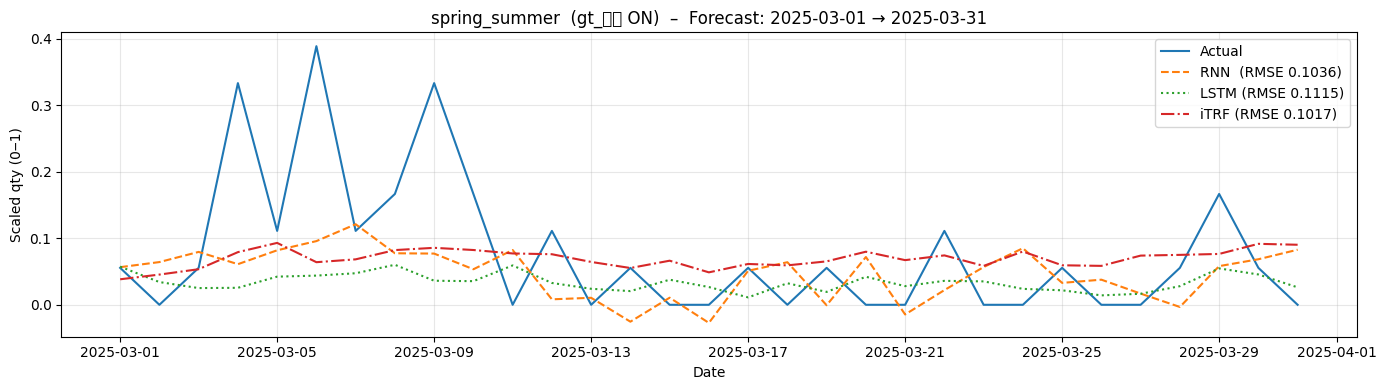

/tmp/ipykernel_62532/2413544167.py:146: UserWarning: Glyph 21476 (\N{CJK UNIFIED IDEOGRAPH-53E4}) missing from font(s) DejaVu Sans.
  plt.legend(); plt.grid(alpha=.3); plt.tight_layout(); plt.show()
/tmp/ipykernel_62532/2413544167.py:146: UserWarning: Glyph 30528 (\N{CJK UNIFIED IDEOGRAPH-7740}) missing from font(s) DejaVu Sans.
  plt.legend(); plt.grid(alpha=.3); plt.tight_layout(); plt.show()
/usr/local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 21476 (\N{CJK UNIFIED IDEOGRAPH-53E4}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 30528 (\N{CJK UNIFIED IDEOGRAPH-7740}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


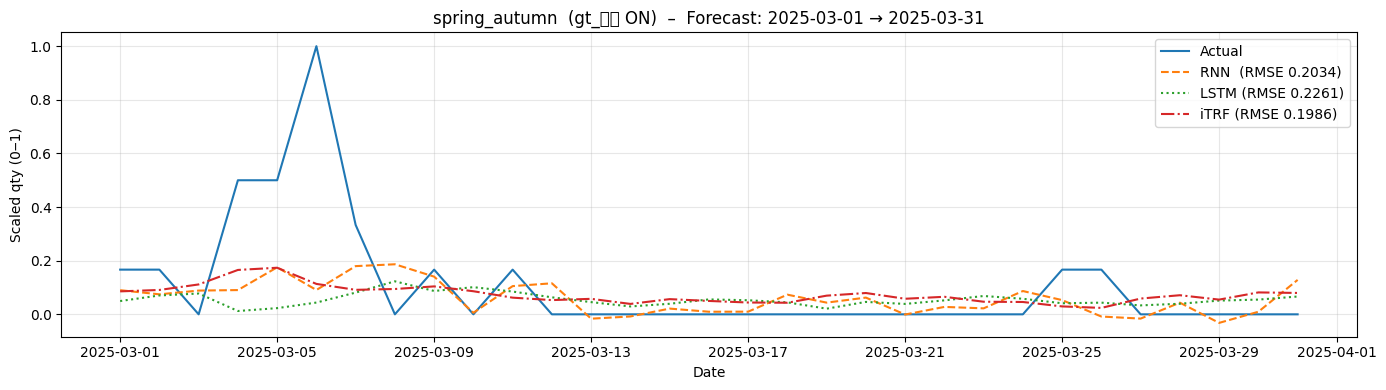

/tmp/ipykernel_62532/2413544167.py:146: UserWarning: Glyph 21476 (\N{CJK UNIFIED IDEOGRAPH-53E4}) missing from font(s) DejaVu Sans.
  plt.legend(); plt.grid(alpha=.3); plt.tight_layout(); plt.show()
/tmp/ipykernel_62532/2413544167.py:146: UserWarning: Glyph 30528 (\N{CJK UNIFIED IDEOGRAPH-7740}) missing from font(s) DejaVu Sans.
  plt.legend(); plt.grid(alpha=.3); plt.tight_layout(); plt.show()
/usr/local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 21476 (\N{CJK UNIFIED IDEOGRAPH-53E4}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 30528 (\N{CJK UNIFIED IDEOGRAPH-7740}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


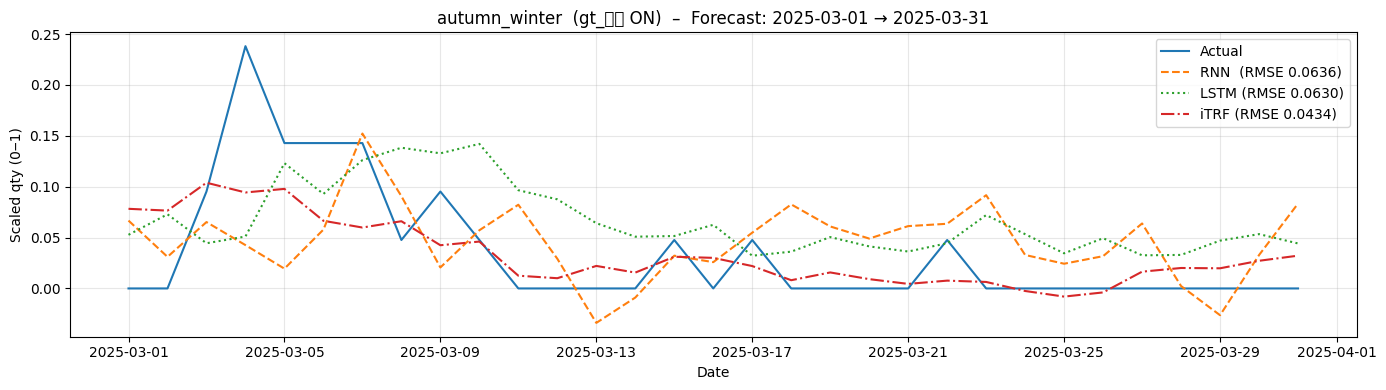


=== gt_古着 ON  RMSE / MAE (scaled) ===
spring_summer    RNN  RMSE 0.1036 | MAE 0.0726   ||  LSTM RMSE 0.1115 | MAE 0.0711   ||  iTRF RMSE 0.1017 | MAE 0.0704
spring_autumn    RNN  RMSE 0.2034 | MAE 0.1081   ||  LSTM RMSE 0.2261 | MAE 0.1277   ||  iTRF RMSE 0.1986 | MAE 0.1207
autumn_winter    RNN  RMSE 0.0636 | MAE 0.0494   ||  LSTM RMSE 0.0630 | MAE 0.0529   ||  iTRF RMSE 0.0434 | MAE 0.0300


/usr/local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


/tmp/ipykernel_62532/2413544167.py:146: UserWarning: Glyph 21476 (\N{CJK UNIFIED IDEOGRAPH-53E4}) missing from font(s) DejaVu Sans.
  plt.legend(); plt.grid(alpha=.3); plt.tight_layout(); plt.show()
/tmp/ipykernel_62532/2413544167.py:146: UserWarning: Glyph 30528 (\N{CJK UNIFIED IDEOGRAPH-7740}) missing from font(s) DejaVu Sans.
  plt.legend(); plt.grid(alpha=.3); plt.tight_layout(); plt.show()
/usr/local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 21476 (\N{CJK UNIFIED IDEOGRAPH-53E4}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 30528 (\N{CJK UNIFIED IDEOGRAPH-7740}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


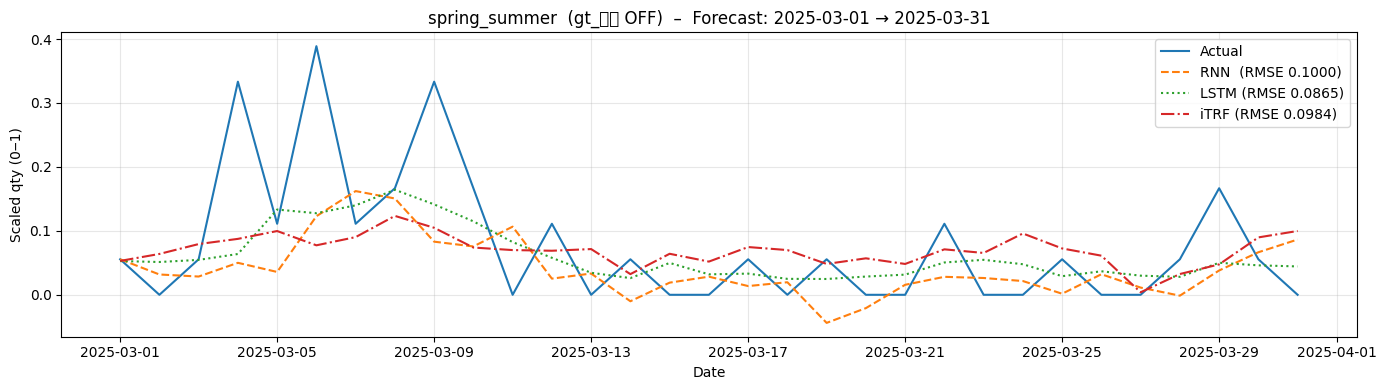

/tmp/ipykernel_62532/2413544167.py:146: UserWarning: Glyph 21476 (\N{CJK UNIFIED IDEOGRAPH-53E4}) missing from font(s) DejaVu Sans.
  plt.legend(); plt.grid(alpha=.3); plt.tight_layout(); plt.show()
/tmp/ipykernel_62532/2413544167.py:146: UserWarning: Glyph 30528 (\N{CJK UNIFIED IDEOGRAPH-7740}) missing from font(s) DejaVu Sans.
  plt.legend(); plt.grid(alpha=.3); plt.tight_layout(); plt.show()
/usr/local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 21476 (\N{CJK UNIFIED IDEOGRAPH-53E4}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 30528 (\N{CJK UNIFIED IDEOGRAPH-7740}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


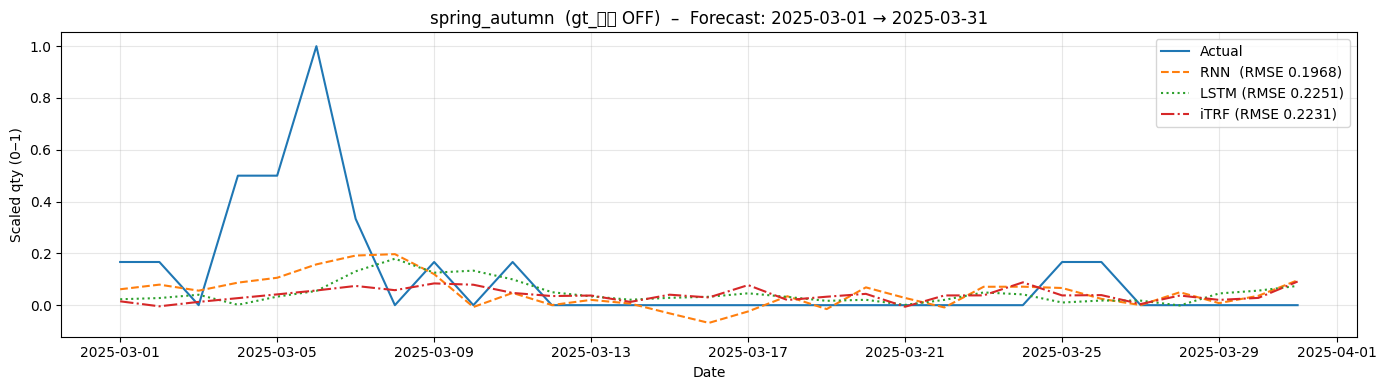

/tmp/ipykernel_62532/2413544167.py:146: UserWarning: Glyph 21476 (\N{CJK UNIFIED IDEOGRAPH-53E4}) missing from font(s) DejaVu Sans.
  plt.legend(); plt.grid(alpha=.3); plt.tight_layout(); plt.show()
/tmp/ipykernel_62532/2413544167.py:146: UserWarning: Glyph 30528 (\N{CJK UNIFIED IDEOGRAPH-7740}) missing from font(s) DejaVu Sans.
  plt.legend(); plt.grid(alpha=.3); plt.tight_layout(); plt.show()
/usr/local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 21476 (\N{CJK UNIFIED IDEOGRAPH-53E4}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 30528 (\N{CJK UNIFIED IDEOGRAPH-7740}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


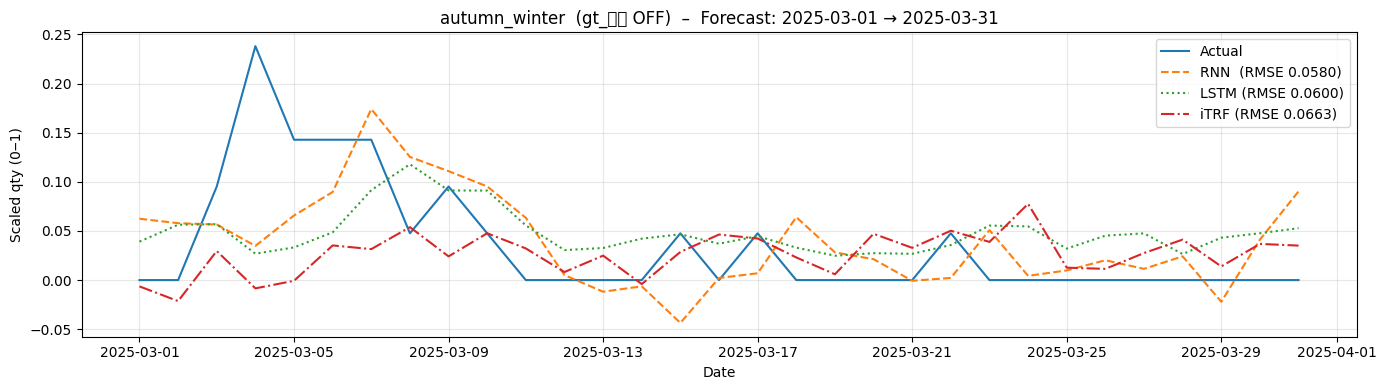


=== gt_古着 OFF  RMSE / MAE (scaled) ===
spring_summer    RNN  RMSE 0.1000 | MAE 0.0690   ||  LSTM RMSE 0.0865 | MAE 0.0567   ||  iTRF RMSE 0.0984 | MAE 0.0687
spring_autumn    RNN  RMSE 0.1968 | MAE 0.1062   ||  LSTM RMSE 0.2251 | MAE 0.1210   ||  iTRF RMSE 0.2231 | MAE 0.1208
autumn_winter    RNN  RMSE 0.0580 | MAE 0.0426   ||  LSTM RMSE 0.0600 | MAE 0.0467   ||  iTRF RMSE 0.0663 | MAE 0.0428


In [2]:
"""
daily_forecast_gt_onoff_v2.py
────────────────────────────
・RNN／LSTM（Keras）＋簡易 iTransformer（PyTorch）
・外部特徴 gt_古着 の有無を自動で比較
・spring_summer / spring_autumn / autumn_winter × (ON / OFF)
    └► 6 枚の折れ線グラフを表示
・コンソールに “全モデル (RNN / LSTM / iTRF) の RMSE と MAE” を出力
"""

# ===============================================================
# 1. 共通ライブラリ
# ===============================================================
import math, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.preprocessing  import MinMaxScaler
from sklearn.metrics        import mean_squared_error, mean_absolute_error
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import torch, torch.nn as nn, torch.optim as optim

# ---------------- パス & 定数 ----------------
CSV  = "../../dataset/forecast_dedicated/daily_usedcloting_sales_data_filled.csv"
cols = ["season_spring_summer", "season_spring_autumn", "season_autumn_winter"]
LB   = 90            # look‑back window（日）
cb   = [EarlyStopping(patience=10, restore_best_weights=True, verbose=0),
        ReduceLROnPlateau(factor=0.5, patience=5, verbose=0)]

# ===============================================================
# 2. モデル定義
# ===============================================================
def build_lstm(seq_len, n_feat):
    m = Sequential([
        LSTM(64, dropout=0.3, recurrent_dropout=0.3,
             input_shape=(seq_len, n_feat)),
        Dense(3)
    ])
    m.compile("adam", "mse")
    return m

class SimpleITR(nn.Module):
    """極小 iTransformer (token = feature)"""
    def __init__(self, seq_len, n_feat, d_model=64, nhead=4, out_dim=3):
        super().__init__()
        self.embed = nn.Linear(seq_len, d_model)
        self.attn  = nn.MultiheadAttention(d_model, nhead, batch_first=True)
        self.head  = nn.Sequential(nn.Flatten(),
                                   nn.Linear(n_feat * d_model, out_dim))
    def forward(self, x):                 # x:[B,L,F]
        x = x.transpose(1, 2)             # [B,F,L]
        h = self.embed(x)                 # [B,F,d]
        h, _ = self.attn(h, h, h)
        return self.head(h)               # [B,out_dim]

# ===============================================================
# 3. ラッパー関数 ── gt_古着 ON / OFF 比較
# ===============================================================
def run_once(use_gt: bool):
    tag = "ON" if use_gt else "OFF"

    # ---------- 3.1 データ読込 ----------
    df = pd.read_csv(CSV, parse_dates=["order_time"]).set_index("order_time")
    if not use_gt and "gt_古着" in df.columns:
        df = df.drop(columns=["gt_古着"])

    train_df = df.loc["2021-06-16":"2024-06-30"]
    val_df   = df.loc["2024-07-01":"2024-11-30"]
    test_df  = df.loc["2024-12-01":"2025-03-31"]

    # ---------- 3.2 スケール ----------
    xs, ys = MinMaxScaler(), MinMaxScaler()
    X_train = xs.fit_transform(train_df.drop(columns=cols)); y_train = ys.fit_transform(train_df[cols])
    X_val   = xs.transform(val_df.drop(columns=cols))      ; y_val   = ys.transform(val_df[cols])
    X_test  = xs.transform(test_df.drop(columns=cols))     ; y_test  = ys.transform(test_df[cols])

    # ---------- 3.3 teach‑data ----------
    def make_xy(X, Y, lb=LB):
        xs, ys = [], []
        for i in range(len(X) - lb):
            xs.append(X[i : i + lb]); ys.append(Y[i + lb])
        return np.asarray(xs, "float32"), np.asarray(ys, "float32")
    trainX, trainY = make_xy(X_train, y_train)
    valX,   valY   = make_xy(X_val,   y_val)
    testX,  testY  = make_xy(X_test,  y_test)
    seq_len, n_feat = trainX.shape[1:3]

    # ---------- 3.4 RNN ----------
    def quick_rnn():
        m = Sequential([
            SimpleRNN(128, return_sequences=True, input_shape=(seq_len, n_feat)),
            Dropout(0.2), SimpleRNN(64), Dropout(0.2), Dense(3)])
        m.compile("adam", "mse"); return m
    K.clear_session(); rnn = quick_rnn()
    rnn.fit(trainX, trainY, epochs=200, batch_size=32,
            validation_data=(valX, valY), callbacks=cb, verbose=0)

    # ---------- 3.5 LSTM ----------
    K.clear_session(); lstm = build_lstm(seq_len, n_feat)
    lstm.fit(trainX, trainY, epochs=200, batch_size=32,
             validation_data=(valX, valY), callbacks=cb, verbose=0)

    # ---------- 3.6 iTRF ----------
    device = "cuda" if torch.cuda.is_available() else "cpu"
    itrf = SimpleITR(seq_len, n_feat).to(device)
    opt, crit = optim.AdamW(itrf.parameters(), 1e-3), nn.MSELoss()
    tl = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(torch.tensor(trainX), torch.tensor(trainY)),
        batch_size=32, shuffle=True)
    vl = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(torch.tensor(valX), torch.tensor(valY)), batch_size=32)
    best, bad = float("inf"), 0
    for _ in range(50):
        itrf.train()
        for xb, yb in tl:
            xb, yb = xb.to(device), yb.to(device)
            opt.zero_grad(); crit(itrf(xb), yb).backward(); opt.step()
        v = np.mean([crit(itrf(x.to(device)), y.to(device)).item() for x, y in vl])
        if v < best: best_state, best, bad = itrf.state_dict(), v, 0
        else: bad += 1
        if bad > 5: break
    itrf.load_state_dict(best_state); itrf.eval()

    # ---------- 3.7 予測 ----------
    pred = {
        "RNN" : rnn.predict(testX, 0),
        "LSTM": lstm.predict(testX, 0),
        "iTRF": itrf(torch.tensor(testX).to(device)).detach().cpu().numpy()
    }

    # ---------- 3.8 グラフ ----------
    idx   = test_df.index[LB:]
    names = ["spring_summer", "spring_autumn", "autumn_winter"]
    for i, n in enumerate(names):
        rm_r = math.sqrt(mean_squared_error(testY[:, i], pred["RNN"] [:, i]))
        rm_l = math.sqrt(mean_squared_error(testY[:, i], pred["LSTM"][:, i]))
        rm_t = math.sqrt(mean_squared_error(testY[:, i], pred["iTRF"][:, i]))

        plt.figure(figsize=(14, 4))
        plt.plot(idx, testY[:, i],            label="Actual")
        plt.plot(idx, pred["RNN"] [:, i], "--", label=f"RNN  (RMSE {rm_r:.4f})")
        plt.plot(idx, pred["LSTM"][:, i], ":",  label=f"LSTM (RMSE {rm_l:.4f})")
        plt.plot(idx, pred["iTRF"][:, i], "-.", label=f"iTRF (RMSE {rm_t:.4f})")
        plt.title(f"{n}  (gt_古着 {tag})  –  Forecast: {idx[0].date()} → {idx[-1].date()}")
        plt.xlabel("Date"); plt.ylabel("Scaled qty (0‒1)")
        plt.legend(); plt.grid(alpha=.3); plt.tight_layout(); plt.show()

    # ---------- 3.9 指標出力 ----------
    print(f"\n=== gt_古着 {tag}  RMSE / MAE (scaled) ===")
    for i, n in enumerate(names):
        rm_r = math.sqrt(mean_squared_error(testY[:, i], pred["RNN"] [:, i]))
        ma_r = mean_absolute_error      (testY[:, i], pred["RNN"] [:, i])
        rm_l = math.sqrt(mean_squared_error(testY[:, i], pred["LSTM"][:, i]))
        ma_l = mean_absolute_error      (testY[:, i], pred["LSTM"][:, i])
        rm_t = math.sqrt(mean_squared_error(testY[:, i], pred["iTRF"][:, i]))
        ma_t = mean_absolute_error      (testY[:, i], pred["iTRF"][:, i])

        print(f"{n:<15}  "
              f"RNN  RMSE {rm_r:6.4f} | MAE {ma_r:6.4f}   ||  "
              f"LSTM RMSE {rm_l:6.4f} | MAE {ma_l:6.4f}   ||  "
              f"iTRF RMSE {rm_t:6.4f} | MAE {ma_t:6.4f}")

# ===============================================================
# 4. 実行 (ON → OFF)  計 6 枚のグラフ＋指標
# ===============================================================
run_once(True)    # gt_古着 あり
run_once(False)   # gt_古着 なし


In [7]:
import matplotlib.pyplot as plt

# 1) 日本語フォントを指定（IPAexGothic が入っている前提）
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = ["IPAexGothic"]

# 2) マイナス記号を正しく表示
plt.rcParams["axes.unicode_minus"] = False


/usr/local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


findfont: Font family 'IPAGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'IPAGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'IPAGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'IPAGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'IPAGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'IPAGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'IPAGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'IPAGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'IPAGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'IPAGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'IPAGoth

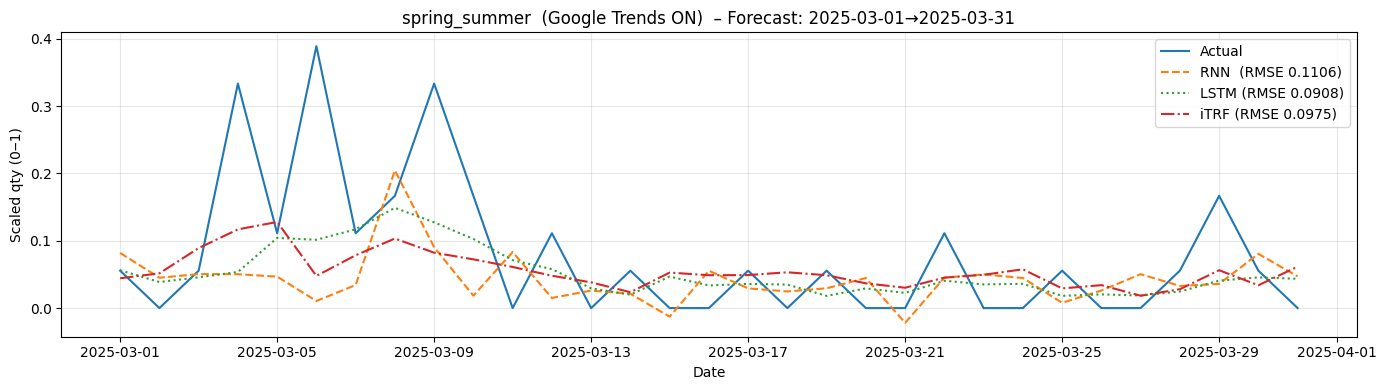

findfont: Font family 'IPAGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'IPAGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'IPAGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'IPAGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'IPAGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'IPAGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'IPAGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'IPAGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'IPAGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'IPAGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'IPAGoth

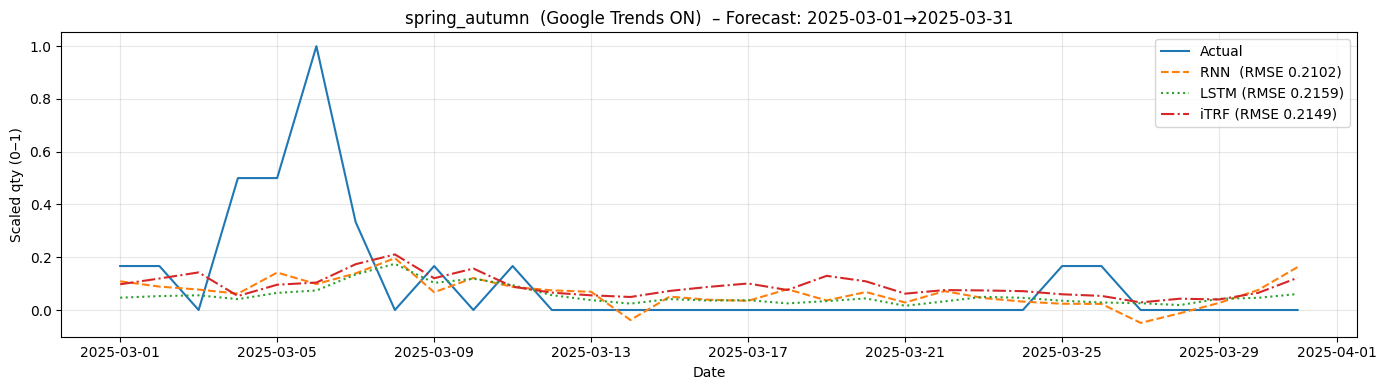

findfont: Font family 'IPAGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'IPAGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'IPAGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'IPAGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'IPAGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'IPAGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'IPAGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'IPAGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'IPAGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'IPAGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'IPAGoth

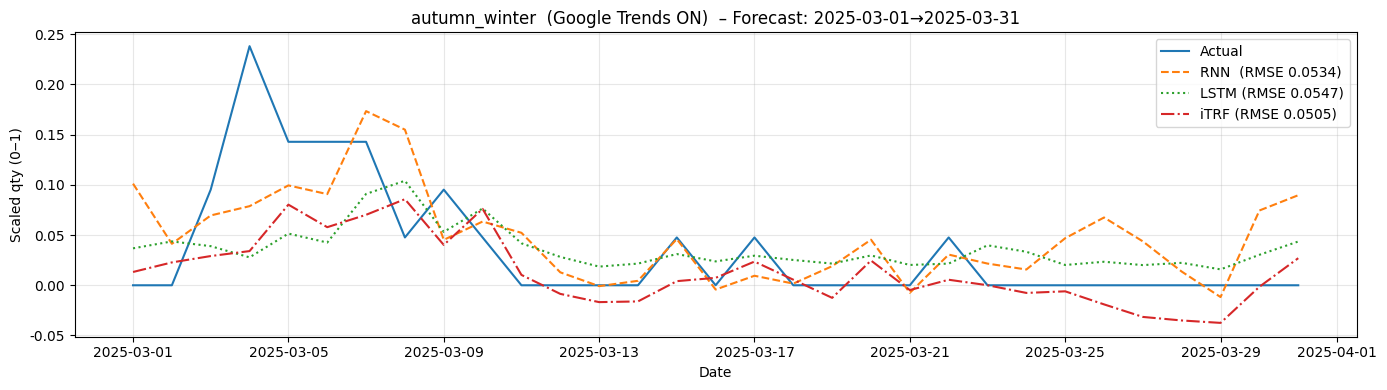


=== Google Trends ON RMSE / MAE (scaled) ===
spring_summer    RNN  RMSE 0.1106 | MAE 0.0732   ||  LSTM RMSE 0.0908 | MAE 0.0567   ||  iTRF RMSE 0.0975 | MAE 0.0650
spring_autumn    RNN  RMSE 0.2102 | MAE 0.1252   ||  LSTM RMSE 0.2159 | MAE 0.1187   ||  iTRF RMSE 0.2149 | MAE 0.1357
autumn_winter    RNN  RMSE 0.0534 | MAE 0.0392   ||  LSTM RMSE 0.0547 | MAE 0.0406   ||  iTRF RMSE 0.0505 | MAE 0.0332


/usr/local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


findfont: Font family 'IPAGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'IPAGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'IPAGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'IPAGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'IPAGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'IPAGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'IPAGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'IPAGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'IPAGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'IPAGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'IPAGoth

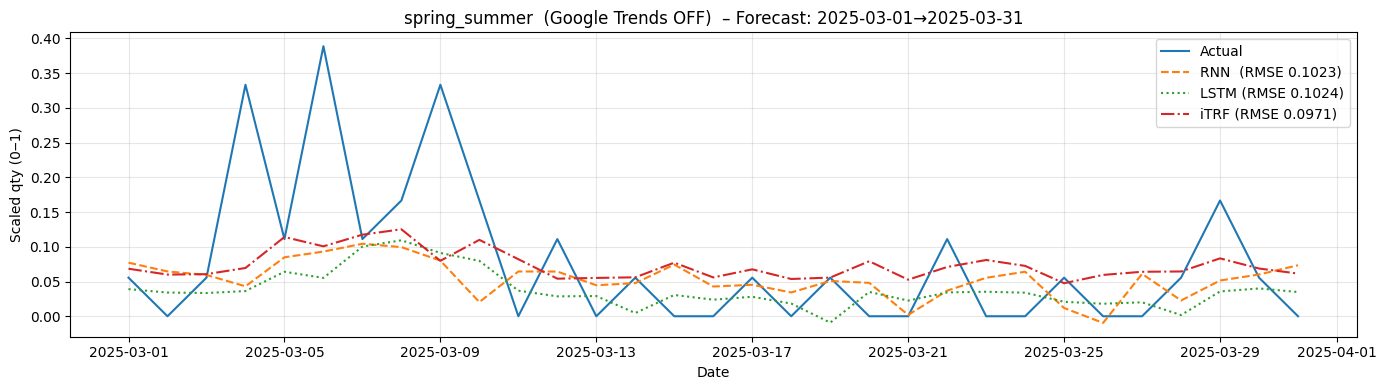

findfont: Font family 'IPAGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'IPAGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'IPAGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'IPAGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'IPAGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'IPAGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'IPAGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'IPAGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'IPAGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'IPAGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'IPAGoth

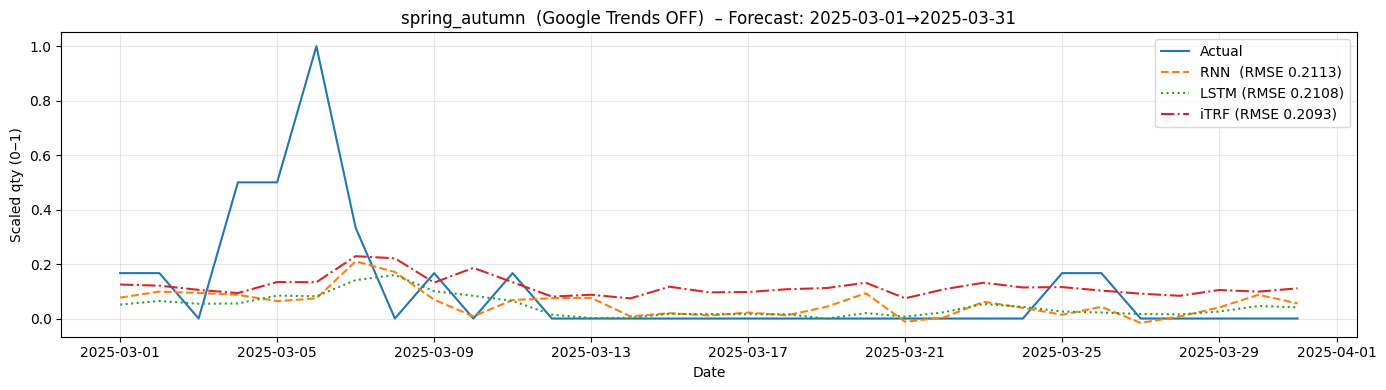

findfont: Font family 'IPAGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'IPAGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'IPAGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'IPAGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'IPAGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'IPAGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'IPAGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'IPAGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'IPAGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'IPAGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'IPAGoth

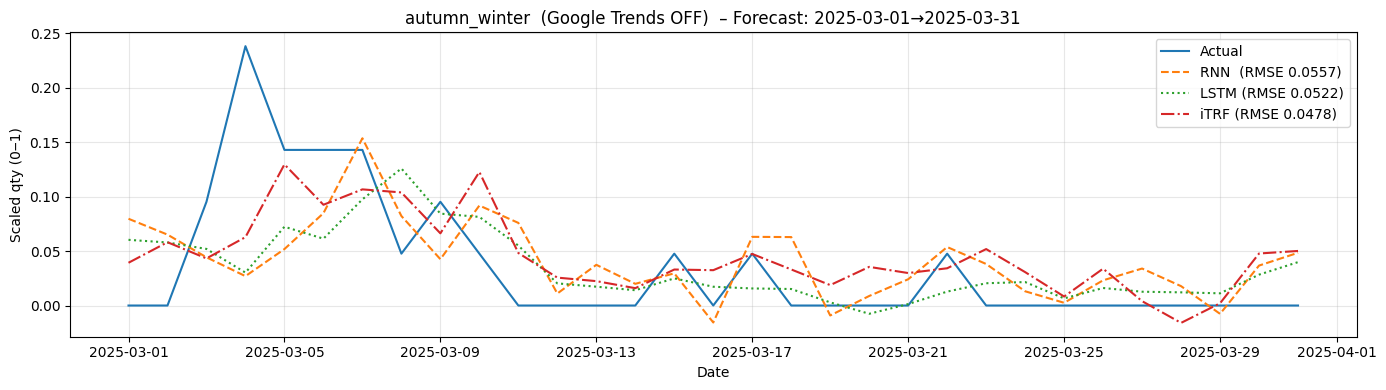


=== Google Trends OFF RMSE / MAE (scaled) ===
spring_summer    RNN  RMSE 0.1023 | MAE 0.0674   ||  LSTM RMSE 0.1024 | MAE 0.0653   ||  iTRF RMSE 0.0971 | MAE 0.0648
spring_autumn    RNN  RMSE 0.2113 | MAE 0.1124   ||  LSTM RMSE 0.2108 | MAE 0.1069   ||  iTRF RMSE 0.2093 | MAE 0.1402
autumn_winter    RNN  RMSE 0.0557 | MAE 0.0395   ||  LSTM RMSE 0.0522 | MAE 0.0354   ||  iTRF RMSE 0.0478 | MAE 0.0361


In [ ]:
"""
daily_forecast_gt_onoff_v3.py
────────────────────────────
・RNN／LSTM（Keras）＋標準 iTransformer（PyTorch）
・外部特徴 gt_古着 の有無を自動で比較
・spring_summer / spring_autumn / autumn_winter × (ON / OFF)
    └► 6 枚の折れ線グラフを表示
・コンソールに “全モデル (RNN / LSTM / iTransformer) の RMSE と MAE” を出力
"""

# ===============================================================
# 1. 共通ライブラリ
# ===============================================================
import math, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.preprocessing  import MinMaxScaler
from sklearn.metrics        import mean_squared_error, mean_absolute_error
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import torch, torch.nn as nn, torch.optim as optim

import matplotlib.pyplot as plt
# IPAフォント or Noto が検出されるようにリスト順で指定
plt.rcParams["font.family"] = ["IPAGothic", "Noto Sans CJK JP", "DejaVu Sans"]
plt.rcParams["axes.unicode_minus"] = False


# ---------------- パス & 定数 ----------------
CSV  = "../../dataset/forecast_dedicated/daily_usedcloting_sales_with_trend.csv"
cols = ["season_spring_summer", "season_spring_autumn", "season_autumn_winter"]
LB   = 90            # look‑back window（日）
cb   = [EarlyStopping(patience=10, restore_best_weights=True, verbose=0),
        ReduceLROnPlateau(factor=0.5, patience=5, verbose=0)]

# ===============================================================
# 2. モデル定義
# ===============================================================
import math

def build_lstm(seq_len, n_feat):
    m = Sequential([
        LSTM(64, dropout=0.3, recurrent_dropout=0.3,
             input_shape=(seq_len, n_feat)),
        Dense(3)
    ])
    m.compile("adam", "mse")
    return m

class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, max_len: int = 5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))  # shape: (1, max_len, d_model)
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: (B, L, d_model)
        return x + self.pe[:, :x.size(1), :]

class ITransformer(nn.Module):
    """標準的な iTransformer 実装: 時系列を埋め込み → 位置エンコーディング → Encoder 層×2 → 出力ヘッド"""
    def __init__(self, seq_len: int, n_feat: int,
                 d_model: int = 64, nhead: int = 4,
                 dim_ff: int = 128, num_layers: int = 2,
                 dropout: float = 0.1, out_dim: int = 3):
        super().__init__()
        # 入力: (B, L, F) → 埋め込み: Linear(F → d_model)
        self.input_proj = nn.Linear(n_feat, d_model)
        # 位置エンコーディング (長さ L × d_model)
        self.pos_enc = PositionalEncoding(d_model, max_len=seq_len)
        # TransformerEncoderLayer × num_layers
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_ff,
            dropout=dropout,
            batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        # 出力ヘッド: 最後の時刻トークンを使う
        self.output_head = nn.Linear(d_model, out_dim)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: (B, L, F)
        h = self.input_proj(x)      # (B, L, d_model)
        h = self.pos_enc(h)         # 〃 + PE
        h = self.encoder(h)         # (B, L, d_model)
        # 最終時刻の埋め込みを出力
        h_last = h[:, -1, :]        # (B, d_model)
        return self.output_head(h_last)  # (B, out_dim)

# ===============================================================
# 3. ラッパー関数 ── gt_古着 ON / OFF 比較
# ===============================================================

def run_once(use_gt: bool):
    tag = "ON" if use_gt else "OFF"

    # ---------- 3.1 データ読込 ----------
    df = pd.read_csv(CSV, parse_dates=["order_time"]).set_index("order_time")
    if not use_gt and "gt_古着" in df.columns:
        df = df.drop(columns=["gt_古着"] )
        # ドロップ後のカラム一覧を出力
        print(f"[gt_古着 {tag}] after drop  columns: {df.columns.tolist()}")
    else:
        # ON のときは drop 処理せず、そのままの一覧を確認
        print(f"[gt_古着 {tag}] no drop, columns: {df.columns.tolist()}")
    
    train_df = df.loc["2021-06-16":"2024-06-30"]
    val_df   = df.loc["2024-07-01":"2024-11-30"]
    test_df  = df.loc["2024-12-01":"2025-03-31"]

    # ---------- 3.2 スケール ----------
    xs, ys = MinMaxScaler(), MinMaxScaler()
    X_train = xs.fit_transform(train_df.drop(columns=cols)); y_train = ys.fit_transform(train_df[cols])
    X_val   = xs.transform(val_df.drop(columns=cols))      ; y_val   = ys.transform(val_df[cols])
    X_test  = xs.transform(test_df.drop(columns=cols))     ; y_test  = ys.transform(test_df[cols])

    # ---------- 3.3 teach‑data ----------
    def make_xy(X, Y, lb=LB):
        xs, ys = [], []
        for i in range(len(X)-lb):
            xs.append(X[i:i+lb]); ys.append(Y[i+lb])
        return np.asarray(xs, "float32"), np.asarray(ys, "float32")
    trainX, trainY = make_xy(X_train, y_train)
    valX,   valY   = make_xy(X_val,   y_val)
    testX,  testY  = make_xy(X_test,  y_test)
    seq_len, n_feat = trainX.shape[1:3]

    # ---------- 3.4 RNN ----------
    def quick_rnn():
        m = Sequential([
            SimpleRNN(128, return_sequences=True, input_shape=(seq_len, n_feat)),
            Dropout(0.2), SimpleRNN(64), Dropout(0.2), Dense(3)
        ])
        m.compile("adam", "mse"); return m
    K.clear_session(); rnn = quick_rnn()
    rnn.fit(trainX, trainY, epochs=200, batch_size=32,
            validation_data=(valX, valY), callbacks=cb, verbose=0)

    # ---------- 3.5 LSTM ----------
    K.clear_session(); lstm = build_lstm(seq_len, n_feat)
    lstm.fit(trainX, trainY, epochs=200, batch_size=32,
             validation_data=(valX, valY), callbacks=cb, verbose=0)

    # ---------- 3.6 iTransformer ----------
    device = "cuda" if torch.cuda.is_available() else "cpu"
    itr = ITransformer(seq_len, n_feat).to(device)
    opt, crit = optim.AdamW(itr.parameters(), lr=1e-3, weight_decay=1e-3), nn.MSELoss()
    tr_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(torch.tensor(trainX), torch.tensor(trainY)),
        batch_size=32, shuffle=True
    )
    val_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(torch.tensor(valX), torch.tensor(valY)),
        batch_size=32, shuffle=False
    )
    best_val, bad = float('inf'), 0
    for epoch in range(50):
        itr.train()
        for xb, yb in tr_loader:
            xb, yb = xb.to(device), yb.to(device)
            opt.zero_grad()
            loss = crit(itr(xb), yb)
            loss.backward()
            nn.utils.clip_grad_norm_(itr.parameters(), 1.0)
            opt.step()
        # validation
        itr.eval(); val_loss = 0.0
        with torch.no_grad():
            for xb, yb in val_loader:
                val_loss += crit(itr(xb.to(device)), yb.to(device)).item()
        val_loss /= len(val_loader)
        if val_loss < best_val:
            best_val, best_state, bad = val_loss, itr.state_dict(), 0
        else:
            bad += 1
            if bad > 5:
                break
    itr.load_state_dict(best_state); itr.eval()

    # ---------- 3.7 予測 ----------
    pred = {
        "RNN":  rnn.predict(testX, 0),
        "LSTM": lstm.predict(testX, 0),
        "iTRF": itr(torch.tensor(testX).to(device)).detach().cpu().numpy()
    }

    # ---------- 3.8 可視化 ----------
    idx   = test_df.index[LB:]
    names = ["spring_summer", "spring_autumn", "autumn_winter"]
    for i, nm in enumerate(names):
        rm_r = math.sqrt(mean_squared_error(testY[:, i], pred["RNN"][:,i]))
        rm_l = math.sqrt(mean_squared_error(testY[:, i], pred["LSTM"][:,i]))
        rm_t = math.sqrt(mean_squared_error(testY[:, i], pred["iTRF"][:,i]))
        plt.figure(figsize=(14,4))
        plt.plot(idx, testY[:,i],             label="Actual")
        plt.plot(idx, pred["RNN"][:,i], "--",  label=f"RNN  (RMSE {rm_r:.4f})")
        plt.plot(idx, pred["LSTM"][:,i], ":",   label=f"LSTM (RMSE {rm_l:.4f})")
        plt.plot(idx, pred["iTRF"][:,i], "-.",  label=f"iTRF (RMSE {rm_t:.4f})")
        plt.title(f"{nm}  (Google Trends {tag})  – Forecast: {idx[0].date()}→{idx[-1].date()}")
        plt.xlabel("Date"); plt.ylabel("Scaled qty (0‒1)")
        plt.legend(); plt.grid(alpha=.3); plt.tight_layout(); plt.show()

    # ---------- 3.9 指標出力 ----------
    print(f"\n=== Google Trends {tag} RMSE / MAE (scaled) ===")
    for i, nm in enumerate(names):
        rm_r = math.sqrt(mean_squared_error(testY[:, i], pred["RNN"][:,i]))
        ma_r = mean_absolute_error       (testY[:, i], pred["RNN"][:,i])
        rm_l = math.sqrt(mean_squared_error(testY[:, i], pred["LSTM"][:,i]))
        ma_l = mean_absolute_error       (testY[:, i], pred["LSTM"][:,i])
        rm_t = math.sqrt(mean_squared_error(testY[:, i], pred["iTRF"][:,i]))
        ma_t = mean_absolute_error       (testY[:, i], pred["iTRF"][:,i])
        print(f"{nm:<15}  "
              f"RNN  RMSE {rm_r:6.4f} | MAE {ma_r:6.4f}   ||  "
              f"LSTM RMSE {rm_l:6.4f} | MAE {ma_l:6.4f}   ||  "
              f"iTRF RMSE {rm_t:6.4f} | MAE {ma_t:6.4f}")

# ===============================================================
# 4. 実行 (ON → OFF)  計 6 枚のグラフ＋指標
# ===============================================================
run_once(True)
run_once(False)


[gt_古着 ON] no drop, columns: ['total_price', 'mall_coupon_discount', 'ship_charge', 'jp_holiday', 'tier_extremely_high', 'tier_high', 'tier_low', 'tier_medium', 'tier_very_high', 'tier_very_low', 'season_spring_summer', 'season_spring_autumn', 'season_autumn_winter', 'cat_accessory', 'cat_bottoms', 'cat_dress', 'cat_other', 'cat_outer', 'cat_suit', 'cat_tops', 'temp_avg_c', 'temp_max_c', 'temp_min_c', 'precip_mm', 'sunshine_h', 'sale_flag_rakuten', 'sale_flag_yahoo', 'wday_clear', 'wday_cloudy', 'wday_mix', 'wday_rain', 'wday_snow', 'wday_thunder', 'wnight_clear', 'wnight_cloudy', 'wnight_mix', 'wnight_rain', 'wnight_snow', 'wnight_thunder', 'week_Friday', 'week_Monday', 'week_Saturday', 'week_Sunday', 'week_Thursday', 'week_Tuesday', 'week_Wednesday', 'gt_古着']


/usr/local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step


findfont: Font family 'IPAGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'IPAGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'IPAGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'IPAGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'IPAGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'IPAGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'IPAGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'IPAGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'IPAGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'IPAGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'IPAGoth

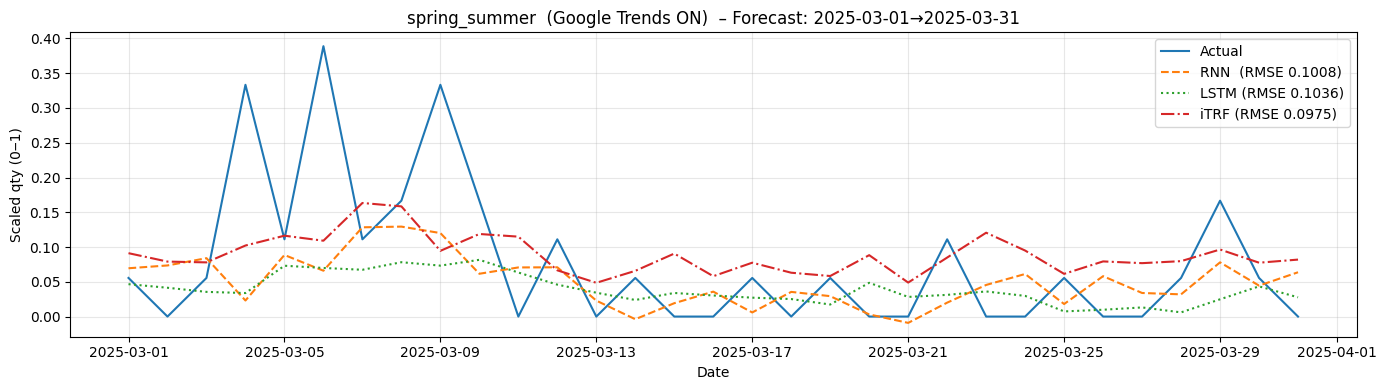

findfont: Font family 'IPAGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'IPAGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'IPAGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'IPAGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'IPAGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'IPAGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'IPAGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'IPAGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'IPAGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'IPAGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'IPAGoth

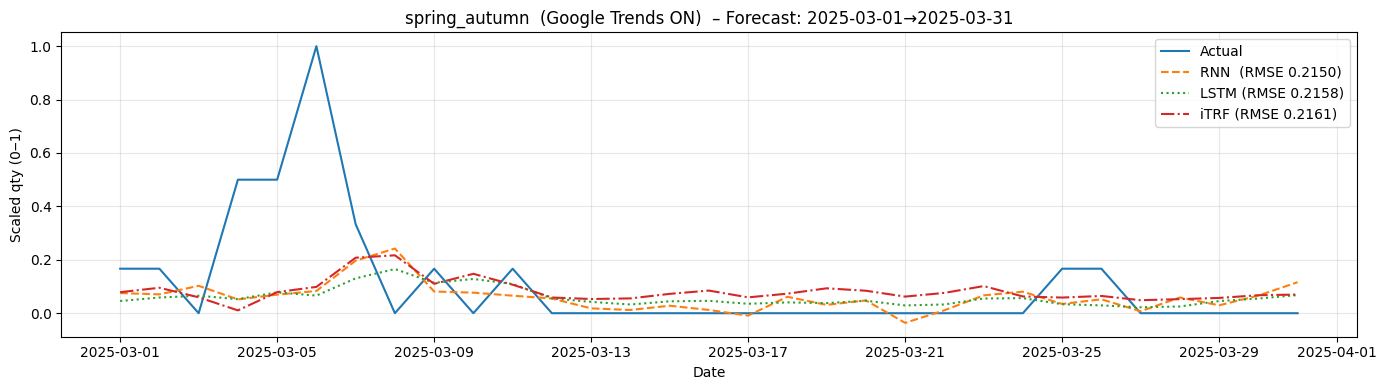

findfont: Font family 'IPAGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'IPAGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'IPAGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'IPAGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'IPAGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'IPAGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'IPAGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'IPAGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'IPAGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'IPAGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'IPAGoth

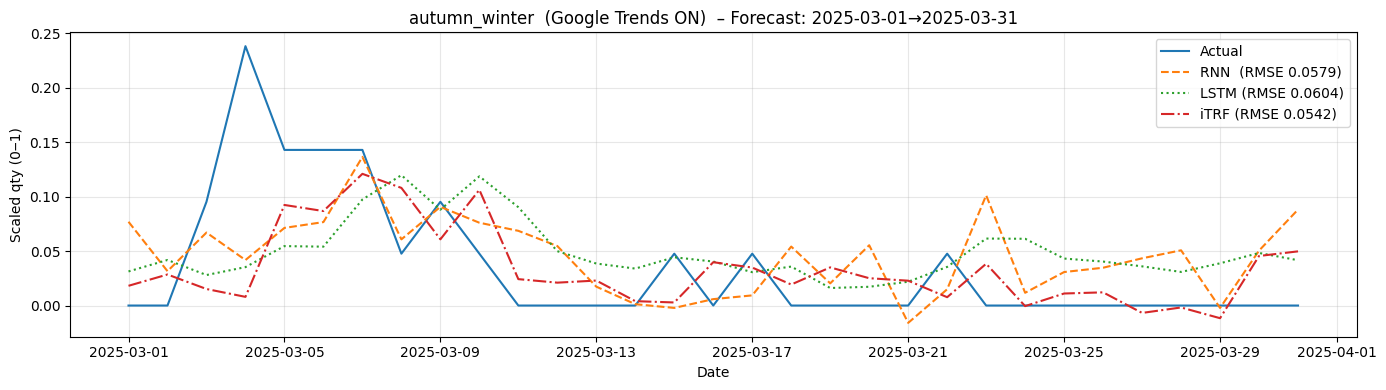


=== Google Trends ON RMSE / MAE (scaled) ===
spring_summer    RNN  RMSE 0.1008 | MAE 0.0655   ||  LSTM RMSE 0.1036 | MAE 0.0671   ||  iTRF RMSE 0.0975 | MAE 0.0708
spring_autumn    RNN  RMSE 0.2150 | MAE 0.1201   ||  LSTM RMSE 0.2158 | MAE 0.1208   ||  iTRF RMSE 0.2161 | MAE 0.1316
autumn_winter    RNN  RMSE 0.0579 | MAE 0.0436   ||  LSTM RMSE 0.0604 | MAE 0.0482   ||  iTRF RMSE 0.0542 | MAE 0.0364
[gt_古着 OFF] after drop  columns: ['total_price', 'mall_coupon_discount', 'ship_charge', 'jp_holiday', 'tier_extremely_high', 'tier_high', 'tier_low', 'tier_medium', 'tier_very_high', 'tier_very_low', 'season_spring_summer', 'season_spring_autumn', 'season_autumn_winter', 'cat_accessory', 'cat_bottoms', 'cat_dress', 'cat_other', 'cat_outer', 'cat_suit', 'cat_tops', 'temp_avg_c', 'temp_max_c', 'temp_min_c', 'precip_mm', 'sunshine_h', 'sale_flag_rakuten', 'sale_flag_yahoo', 'wday_clear', 'wday_cloudy', 'wday_mix', 'wday_rain', 'wday_snow', 'wday_thunder', 'wnight_clear', 'wnight_cloudy', 'wnig

/usr/local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


findfont: Font family 'IPAGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'IPAGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'IPAGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'IPAGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'IPAGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'IPAGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'IPAGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'IPAGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'IPAGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'IPAGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'IPAGoth

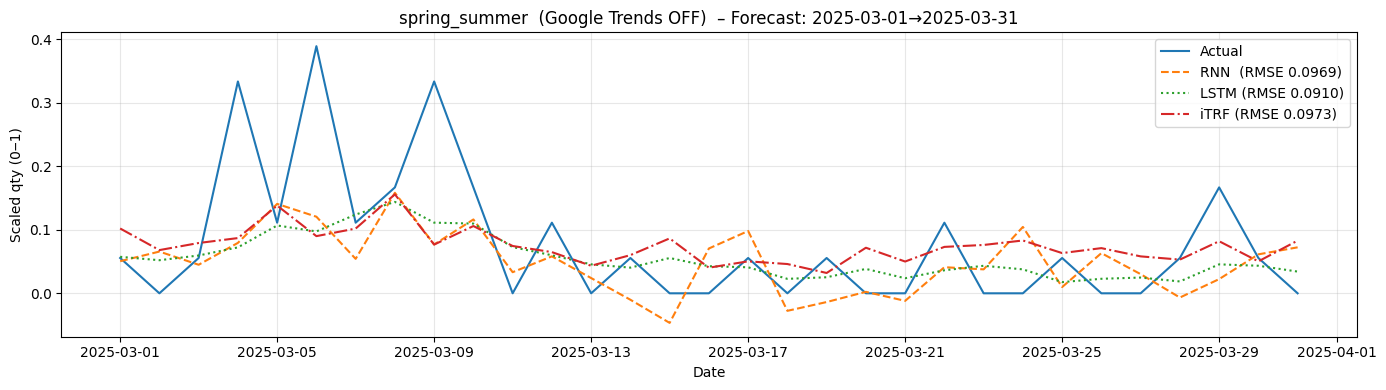

findfont: Font family 'IPAGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'IPAGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'IPAGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'IPAGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'IPAGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'IPAGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'IPAGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'IPAGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'IPAGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'IPAGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'IPAGoth

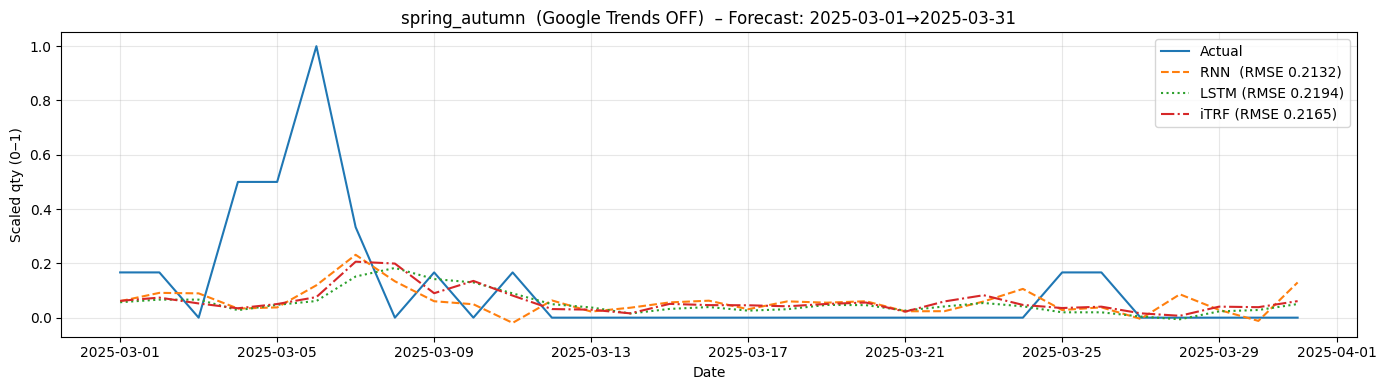

findfont: Font family 'IPAGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'IPAGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'IPAGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'IPAGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'IPAGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'IPAGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'IPAGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'IPAGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'IPAGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'IPAGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'IPAGoth

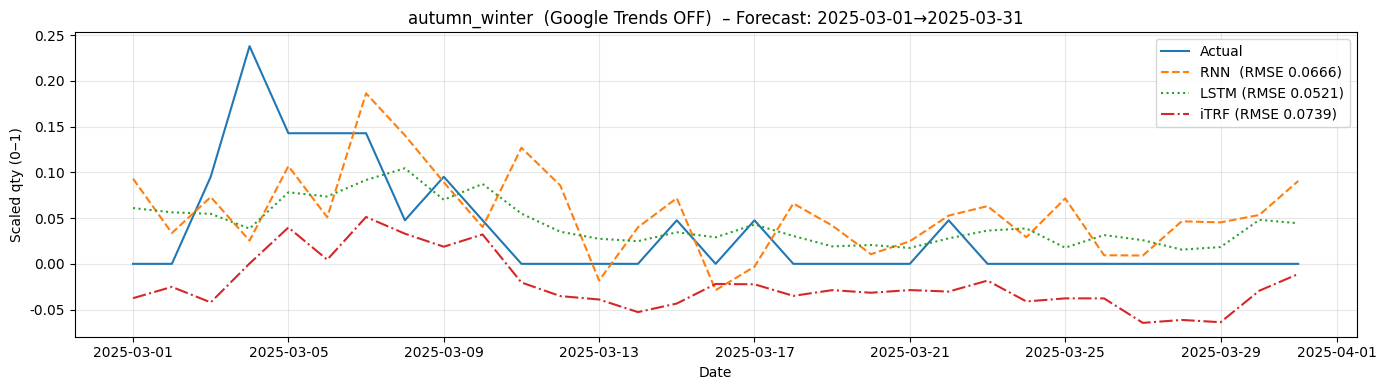


=== Google Trends OFF RMSE / MAE (scaled) ===
spring_summer    RNN  RMSE 0.0969 | MAE 0.0674   ||  LSTM RMSE 0.0910 | MAE 0.0577   ||  iTRF RMSE 0.0973 | MAE 0.0661
spring_autumn    RNN  RMSE 0.2132 | MAE 0.1241   ||  LSTM RMSE 0.2194 | MAE 0.1171   ||  iTRF RMSE 0.2165 | MAE 0.1198
autumn_winter    RNN  RMSE 0.0666 | MAE 0.0510   ||  LSTM RMSE 0.0521 | MAE 0.0399   ||  iTRF RMSE 0.0739 | MAE 0.0573


In [3]:
"""
daily_forecast_gt_onoff_v3.py
────────────────────────────
・RNN／LSTM（Keras）＋標準 iTransformer（PyTorch）
・外部特徴 gt_古着 の有無を自動で比較
・spring_summer / spring_autumn / autumn_winter × (ON / OFF)
    └► 6 枚の折れ線グラフを表示
・コンソールに “全モデル (RNN / LSTM / iTransformer) の RMSE と MAE” を出力
"""

# ===============================================================
# 1. 共通ライブラリ
# ===============================================================
import math, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.preprocessing  import MinMaxScaler
from sklearn.metrics        import mean_squared_error, mean_absolute_error
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import torch, torch.nn as nn, torch.optim as optim

import matplotlib.pyplot as plt
# IPAフォント or Noto が検出されるようにリスト順で指定
plt.rcParams["font.family"] = ["IPAGothic", "Noto Sans CJK JP", "DejaVu Sans"]
plt.rcParams["axes.unicode_minus"] = False


# ---------------- パス & 定数 ----------------
CSV  = "../../dataset/forecast_dedicated/daily_usedcloting_sales_with_trend.csv"
cols = ["season_spring_summer", "season_spring_autumn", "season_autumn_winter"]
LB   = 90            # look‑back window（日）
cb   = [EarlyStopping(patience=10, restore_best_weights=True, verbose=0),
        ReduceLROnPlateau(factor=0.5, patience=5, verbose=0)]

# ===============================================================
# 2. モデル定義
# ===============================================================
import math

def build_lstm(seq_len, n_feat):
    m = Sequential([
        LSTM(64, dropout=0.3, recurrent_dropout=0.3,
             input_shape=(seq_len, n_feat)),
        Dense(3)
    ])
    m.compile("adam", "mse")
    return m

class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, max_len: int = 5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))  # shape: (1, max_len, d_model)
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: (B, L, d_model)
        return x + self.pe[:, :x.size(1), :]

class ITransformer(nn.Module):
    """標準的な iTransformer 実装: 時系列を埋め込み → 位置エンコーディング → Encoder 層×2 → 出力ヘッド"""
    def __init__(self, seq_len: int, n_feat: int,
                 d_model: int = 64, nhead: int = 4,
                 dim_ff: int = 128, num_layers: int = 2,
                 dropout: float = 0.1, out_dim: int = 3):
        super().__init__()
        # 入力: (B, L, F) → 埋め込み: Linear(F → d_model)
        self.input_proj = nn.Linear(n_feat, d_model)
        # 位置エンコーディング (長さ L × d_model)
        self.pos_enc = PositionalEncoding(d_model, max_len=seq_len)
        # TransformerEncoderLayer × num_layers
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_ff,
            dropout=dropout,
            batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        # 出力ヘッド: 最後の時刻トークンを使う
        self.output_head = nn.Linear(d_model, out_dim)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: (B, L, F)
        h = self.input_proj(x)      # (B, L, d_model)
        h = self.pos_enc(h)         # 〃 + PE
        h = self.encoder(h)         # (B, L, d_model)
        # 最終時刻の埋め込みを出力
        h_last = h[:, -1, :]        # (B, d_model)
        return self.output_head(h_last)  # (B, out_dim)

# ===============================================================
# 3. ラッパー関数 ── gt_古着 ON / OFF 比較
# ===============================================================

def run_once(use_gt: bool):
    tag = "ON" if use_gt else "OFF"

    # ---------- 3.1 データ読込 ----------
    df = pd.read_csv(CSV, parse_dates=["order_time"]).set_index("order_time")
    if not use_gt and "gt_古着" in df.columns:
        df = df.drop(columns=["gt_古着"] )
        # ドロップ後のカラム一覧を出力
        print(f"[gt_古着 {tag}] after drop  columns: {df.columns.tolist()}")
    else:
        # ON のときは drop 処理せず、そのままの一覧を確認
        print(f"[gt_古着 {tag}] no drop, columns: {df.columns.tolist()}")
    
    train_df = df.loc["2021-06-16":"2024-06-30"]
    val_df   = df.loc["2024-07-01":"2024-11-30"]
    test_df  = df.loc["2024-12-01":"2025-03-31"]

    # ---------- 3.2 スケール ----------
    xs, ys = MinMaxScaler(), MinMaxScaler()
    X_train = xs.fit_transform(train_df.drop(columns=cols)); y_train = ys.fit_transform(train_df[cols])
    X_val   = xs.transform(val_df.drop(columns=cols))      ; y_val   = ys.transform(val_df[cols])
    X_test  = xs.transform(test_df.drop(columns=cols))     ; y_test  = ys.transform(test_df[cols])

    # ---------- 3.3 teach‑data ----------
    def make_xy(X, Y, lb=LB):
        xs, ys = [], []
        for i in range(len(X)-lb):
            xs.append(X[i:i+lb]); ys.append(Y[i+lb])
        return np.asarray(xs, "float32"), np.asarray(ys, "float32")
    trainX, trainY = make_xy(X_train, y_train)
    valX,   valY   = make_xy(X_val,   y_val)
    testX,  testY  = make_xy(X_test,  y_test)
    seq_len, n_feat = trainX.shape[1:3]

    # ---------- 3.4 RNN ----------
    def quick_rnn():
        m = Sequential([
            SimpleRNN(128, return_sequences=True, input_shape=(seq_len, n_feat)),
            Dropout(0.2), SimpleRNN(64), Dropout(0.2), Dense(3)
        ])
        m.compile("adam", "mse"); return m
    K.clear_session(); rnn = quick_rnn()
    rnn.fit(trainX, trainY, epochs=200, batch_size=32,
            validation_data=(valX, valY), callbacks=cb, verbose=0)

    # ---------- 3.5 LSTM ----------
    K.clear_session(); lstm = build_lstm(seq_len, n_feat)
    lstm.fit(trainX, trainY, epochs=200, batch_size=32,
             validation_data=(valX, valY), callbacks=cb, verbose=0)

    # ---------- 3.6 iTransformer ----------
    device = "cuda" if torch.cuda.is_available() else "cpu"
    itr = ITransformer(seq_len, n_feat).to(device)
    opt, crit = optim.AdamW(itr.parameters(), lr=1e-3, weight_decay=1e-3), nn.MSELoss()
    tr_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(torch.tensor(trainX), torch.tensor(trainY)),
        batch_size=32, shuffle=True
    )
    val_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(torch.tensor(valX), torch.tensor(valY)),
        batch_size=32, shuffle=False
    )
    best_val, bad = float('inf'), 0
    for epoch in range(50):
        itr.train()
        for xb, yb in tr_loader:
            xb, yb = xb.to(device), yb.to(device)
            opt.zero_grad()
            loss = crit(itr(xb), yb)
            loss.backward()
            nn.utils.clip_grad_norm_(itr.parameters(), 1.0)
            opt.step()
        # validation
        itr.eval(); val_loss = 0.0
        with torch.no_grad():
            for xb, yb in val_loader:
                val_loss += crit(itr(xb.to(device)), yb.to(device)).item()
        val_loss /= len(val_loader)
        if val_loss < best_val:
            best_val, best_state, bad = val_loss, itr.state_dict(), 0
        else:
            bad += 1
            if bad > 5:
                break
    itr.load_state_dict(best_state); itr.eval()

    # ---------- 3.7 予測 ----------
    pred = {
        "RNN":  rnn.predict(testX, 0),
        "LSTM": lstm.predict(testX, 0),
        "iTRF": itr(torch.tensor(testX).to(device)).detach().cpu().numpy()
    }

    # ---------- 3.8 可視化 ----------
    idx   = test_df.index[LB:]
    names = ["spring_summer", "spring_autumn", "autumn_winter"]
    for i, nm in enumerate(names):
        rm_r = math.sqrt(mean_squared_error(testY[:, i], pred["RNN"][:,i]))
        rm_l = math.sqrt(mean_squared_error(testY[:, i], pred["LSTM"][:,i]))
        rm_t = math.sqrt(mean_squared_error(testY[:, i], pred["iTRF"][:,i]))
        plt.figure(figsize=(14,4))
        plt.plot(idx, testY[:,i],             label="Actual")
        plt.plot(idx, pred["RNN"][:,i], "--",  label=f"RNN  (RMSE {rm_r:.4f})")
        plt.plot(idx, pred["LSTM"][:,i], ":",   label=f"LSTM (RMSE {rm_l:.4f})")
        plt.plot(idx, pred["iTRF"][:,i], "-.",  label=f"iTRF (RMSE {rm_t:.4f})")
        plt.title(f"{nm}  (Google Trends {tag})  – Forecast: {idx[0].date()}→{idx[-1].date()}")
        plt.xlabel("Date"); plt.ylabel("Scaled qty (0‒1)")
        plt.legend(); plt.grid(alpha=.3); plt.tight_layout(); plt.show()

    # ---------- 3.9 指標出力 ----------
    print(f"\n=== Google Trends {tag} RMSE / MAE (scaled) ===")
    for i, nm in enumerate(names):
        rm_r = math.sqrt(mean_squared_error(testY[:, i], pred["RNN"][:,i]))
        ma_r = mean_absolute_error       (testY[:, i], pred["RNN"][:,i])
        rm_l = math.sqrt(mean_squared_error(testY[:, i], pred["LSTM"][:,i]))
        ma_l = mean_absolute_error       (testY[:, i], pred["LSTM"][:,i])
        rm_t = math.sqrt(mean_squared_error(testY[:, i], pred["iTRF"][:,i]))
        ma_t = mean_absolute_error       (testY[:, i], pred["iTRF"][:,i])
        print(f"{nm:<15}  "
              f"RNN  RMSE {rm_r:6.4f} | MAE {ma_r:6.4f}   ||  "
              f"LSTM RMSE {rm_l:6.4f} | MAE {ma_l:6.4f}   ||  "
              f"iTRF RMSE {rm_t:6.4f} | MAE {ma_t:6.4f}")

# ===============================================================
# 4. 実行 (ON → OFF)  計 6 枚のグラフ＋指標
# ===============================================================
run_once(True)
run_once(False)
